In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split)
    
RANDOM_STATE = 1122

In [68]:
from sklearn.metrics import f1_score, accuracy_score

# Постановка задачи

Организация выдает займы физическим лицам.  

Необходимо:
1. Выполнить анализ и охарактеризовать клиентский портфель организации
2. Построить базовую модель прогнозирования банкротства, одобряющую не менее 35% клиентов при банкротстве среди одобренных не выше 15%.  
3. Подготовить рекомендации и предложения по изменению признакового пространства, использованию внешних данных и иному развитию базовой модели.  

Постановка задачи машинного обучения:  
Будем решать задачу **БИНАРНОЙ КЛАССИФИКАЦИИ.**

В работе датасет клиентов, которые получили кредит.  
Мы имеем целевую переменную **target** - клиенты-банкроты. 

Исходя из требования, что необходимо построить модель, одобряющую не менее 35% клиентов, т.е. целевой класс предсказания у этих клиентов должен быть 0 (не банкроты).  

Если посмотреть на эту задачу с точки зрения интерпритации матрицы ошибок:  

TN (True Negative) - клиенты, которые получили кредит и не будут банкротом.  
FN (False Negative) - клиенты которым мы выдадим кредит но они станут банкротом.  

Задачу машинного обучения сформулирую следующим образом:  
**TN + FN >= 35% от всех клиентов  
FN / TN <= 15%**

# Загрузка и проверка данных

In [2]:
df = pd.read_csv('datasets/analytics_prog_decisions_task/new_training_data_31_08_2022.csv', sep = ',')
df_reject = pd.read_csv('datasets/analytics_prog_decisions_task/all_reject_data.csv', sep = ',')

In [3]:
df.head()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0


In [4]:
df_reject.head()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,4,35.0,903.0,44683.0,0.0,43335.0,3.0,0.0,0.0,3500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056551
1,6,32.0,4.0,0.0,0.0,1.0,31.0,361.0,0.0,403828.0,...,0.0,16.0,0.0,0.0,35.0,0.0,0.0,14.0,0.0,NaN
2,9,25.0,17.0,0.0,0.0,1.0,31.0,29.0,0.0,401027.0,...,0.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,59.0,0.557095
3,10,42.0,2.0,0.0,0.0,1.0,38.0,206.0,0.0,844402.0,...,0.0,26.0,0.0,0.0,12.0,0.0,0.0,11.0,29.0,0.092473
4,12,38.0,204.0,73.0,0.0,1.0,39.0,98.0,0.0,600680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.084674


В датасете df_reject нет одного столбца (**target)**.

Посмотрим какие данные в датасете, есть ли пропуски в столбцах:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42529 entries, 0 to 42528
Data columns (total 75 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            42529 non-null  int64  
 1   age                                   42529 non-null  float64
 2   lastcredit                            42529 non-null  float64
 3   time_to_lastcredit_closeddt           42529 non-null  float64
 4   close_loan_median                     42520 non-null  float64
 5   open_loan_median                      42520 non-null  float64
 6   is_active_100                         42529 non-null  float64
 7   isnt_active_100                       42529 non-null  float64
 8   is_lost_100                           42529 non-null  float64
 9   micro_loans_active_100                42529 non-null  float64
 10  is_active_12                          42529 non-null  float64
 11  open_sum_12    

Из информации о датасете видно, что все признаки числовые. Позже буду принимать решение о необходисти категоризировать количественные признаки.  
Также есть пропуски в данных.

Временно заменим столбце с назваием **Unnamed: 0** на **id.**  
По существу показатель очень похож на индекс "клиента" из общего датасета, который был разделен на клиентов, которые получили кредит (new_training_data_31_08_2022.csv) и на клиентов и второй файл (all_reject_data.csv).  

In [6]:
df.rename(columns = {'Unnamed: 0'  : 'id'}, inplace=True)
df

,id,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42524,35680,51.0,4.0,0.0,0.0,5.0,18.0,52.0,3.0,287540.0,...,12.0,0.0,0.0,5.0,0.0,0.0,4.0,120.0,-1.998618,0.0
42525,35681,44.0,4.0,0.0,0.0,1.5,30.0,110.0,7.0,283504.0,...,18.0,0.0,1.0,18.0,0.0,1.0,13.0,120.0,0.083334,1.0
42526,35682,28.0,27.0,0.0,0.0,514.0,1.0,4.0,1.0,7000.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.285714,0.0
42527,35683,35.0,8.0,0.0,0.0,1.0,20.0,43.0,1.0,258844.0,...,16.0,0.0,0.0,10.0,0.0,0.0,9.0,120.0,0.075319,1.0


Создадим словарь с названиями столбцов, для более простой интерпритации при необходимости (визуализация и пр)

In [7]:
dict_name = {
     'id' : 'номер наблюдения',
     'age' : 'Возраст заемщика',
     'lastcredit' : 'Время в днях, которое прошло с момента открытия последнего кредитного продукта',
     'time_to_lastcredit_closeddt'  : 'Время в днях, которое прошло с момента закрытия последнего микрокредита (если есть активные кредиты, эта переменная будет равна 0)',
     'close_loan_median' : 'Медиана, взятая по количеству дней между закрытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между закрытием предыдущего и следующего микрокредита',
     'open_loan_median' : 'Медиана, взятая по количеству дней между открытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между открытием предыдущего и следующего микрокредита',
     'is_active_100' : 'Количество активных кредитов, открытых за все время',
     'isnt_active_100' : 'Количество не возвращенных кредитов относительно всех кредитов, взятых за все время',
     'is_lost_100' : 'Невозвращенные кредиты, открытые за все время (например, переданные по цессии)',
     'micro_loans_active_100' : 'Активная сумма микрокредитов, открытых за всё время',
     'is_active_12' : 'Количество всех активных кредитов, открытых за последние 12 месяцев',
     'open_sum_12' : 'Активная сумма кредитов, взятых за последние 12 месяцев',
     'isnt_active_12' : 'Количество закрытых кредитов, которые были открыты за последние 12 месяцев',
     'is_lost_12' : 'Невозвращенные кредиты, открытые за последние 12 месяцев',
     'overdue_loans_12' : 'Количество просроченных кредитов, открытых за последние 12 месяцев',
     'micro_loans_active_12' : 'Активная сумма микрокредитов, открытых за последние 12 месяцев',
     'is_active_3' : 'Количество всех активных кредитов, открытых за последние 3 месяца',
     'open_sum_3' : 'Активная сумма кредитов, взятых за последние 3 месяца',
     'isnt_active_3' : 'Количество закрытых кредитов, которые были открыты за последние 3 месяца',
     'is_lost_3' : 'Невозвращенные кредиты, открытые за последние 3 месяца',
     'overdue_loans_3' : 'Количество просроченных кредитов, открытых за последние 3 месяца',
     'micro_loans_active_3' : 'Активная сумма микрокредитов, открытых за последние 3 месяца',
     'is_active_1' : 'Количество всех активных кредитов, открытых за последний месяц',
     'open_sum_1' : 'Активная сумма кредитов, взятых за последний месяц',
     'isnt_active_1' : 'Количество закрытых кредитов, которые были открыты за последний месяц',
     'is_lost_1' : 'Невозвращенные кредиты, открытые за последний месяц (например, переданные по цессии)',
     'micro_loans_active_1' : 'Активная сумма микрокредитов, открытых за последний месяц',
     'ratio_all_microloans_3_to_12' : 'Отношение количества микрокредитов, взятых за последние 3 месяца, к количеству микрокредитов, взятых за последние 12 месяцев',
     'ratio_overdue_loans_3_to_12' : 'Отношение количества просроченных микрокредитов, взятых за последние 3 месяца, к количеству просроченных микрокредитов, взятых за последние 12 месяцев',
     'ratio_history_100' : 'Доля не возвращенных кредитов относительно всех кредитов, взятых за все время',
     'ratio_history_12' : 'Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 12 месяцев',
     'fraction_last_x_12' : 'Доля кредитов, взятых за последние 12 месяцев, относительно всех кредитов истории',
     'ratio_history_3' : 'Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 3 месяца',
     'fraction_last_x_3' : 'Доля кредитов, взятых за последние 3 месяца, относительно всех кредитов истории',
     'ratio_history_1' : 'Доля не возвращенных кредитов относительно всех кредитов, взятых за последний месяц',
     'fraction_last_x_1' : 'Доля кредитов, взятых за последний месяц, относительно всех кредитов истории',
     'mean_delay_100_with_lag' : 'Средняя просрочка за всё время (с лагом по времени в 2 месяца)',
     'mean_delay_12_with_lag' : 'Средняя просрочка за последние 12 месяцев (с лагом по времени в 2 месяца)',
     'mean_delay_3_with_lag' : 'Средняя просрочка за последние 3 месяца (с лагом по времени в 2 месяца)',
     'mean_delay_1_with_lag' : 'Средняя просрочка за последний месяц (с лагом по времени в 2 месяца)',
     'ratio_mean_delay_3_to_12' : 'Отношение средней просрочки за последние 3 месяца к средней просрочке за последние 12 месяцев (в днях, с лагом по времени в 2 месяца)',
     'count_all_credits' : 'Количество всех кредитов в истории',
     'ratio_pattern_len_to_pattern_1' : 'Отношение количества платежей в платежном паттерне к общему количеству запланированных платежей на данный момент',
     'ratio_pattern_len_to_pattern_2' : 'Отношение количества просрочек в 0:5 дней в платежном паттерне к общему количеству запланированных платежей на данный момент',
     'ratio_pattern_len_to_pattern_3' : 'Отношение количества просрочек в 6:30 дней в платежном паттерне к общему количеству запланированных платежей на данный момент',
     'ratio_pattern_len_to_pattern_4' : 'Отношение количества просрочек в 31:60 дней в платежном паттерне к общему количеству запланированных платежей на данный момент',
     'ratio_pattern_len_to_pattern_bad_len' : 'Отношение количества символов сильной просрочки (> 60 дней) в платежном паттерне к общему количеству символов в строке',
     'last_microloan_openeddt' : 'Время в днях, которое прошло с момента открытия последнего микрокредита',
     'is_type_credit_card_100' : 'Количество кредитов типа кредитная карта, открытых за всё время',
     'is_type_consumer_100' : 'Количество кредитов типа потребительский кредит, открытых за всё время',
     'is_type_micro_100' : 'Количество кредитов типа микрокредит, открытых за всё время',
     'is_active_type_credit_card_100' : 'Количество активных кредитов, открытых за всё время с типом займа  кредитная карта',
     'is_active_type_consumer_100' : 'Количество активных кредитов, открытых за всё время с типом займа  потребительский кредит',
     'is_active_type_micro_100' : 'Количество активных кредитов, открытых за все время с типом займа  микрокредит',
     'is_type_credit_card_12' : 'Количество кредитов типа кредитная карта, открытых за последние 12 месяцев',
     'is_type_consumer_12' : 'Количество кредитов типа потребительский кредит, открытых за последние 12 месяцев',
     'is_type_micro_12' : 'Количество кредитов типа микрокредит, открытых за последние 12 месяцев',
     'is_active_type_credit_card_12' : 'Количество активных кредитов, открытых за последние 12 месяцев с типом займа  кредитная карта',
     'is_active_type_consumer_12' : 'Количество активных кредитов, открытых за последние 12 месяцев с типом займа  потребительский кредит',
     'is_active_type_micro_12' : 'Количество активных кредитов, открытых за последние 12 месяцев с типом займа  микрокредит',
     'is_type_credit_card_3' : 'Количество кредитов типа кредитная карта, открытых за последние 3 месяца',
     'is_type_consumer_3' : 'Количество кредитов типа потребительский кредит , открытых за последние 3 месяца',
     'is_type_micro_3' : 'Количество кредитов типа микрокредит, открытых за последние 3 месяца',
     'is_active_type_credit_card_3' : 'Количество активных кредитов, открытых за последние 3 месяца с типом займа  кредитная карта',
     'is_active_type_consumer_3' : 'Количество активных кредитов, открытых за последние 3 месяца с типом займа  потребительский кредит',
     'is_active_type_micro_3' : 'Количество активных кредитов, открытых за последние 3 месяца с типом займа  микрокредит',
     'is_type_credit_card_1' : 'Количество кредитов типа кредитная карта, открытых за последние 12 месяцев',
     'is_type_consumer_1' : 'Количество кредитов типа потребительский кредит, открытых за последний месяц',
     'is_type_micro_1' : 'Количество кредитов типа микрокредит, открытых за последний месяц',
     'is_active_type_credit_card_1' : 'Количество активных кредитов, открытых за последние 12 месяцев с типом займа  кредитная карта',
     'is_active_type_consumer_1' : 'Количество активных кредитов, открытых за последний 1 месяц с типом займа  потребительский кредит',
     'is_active_type_micro_1' : 'Количество активных кредитов, открытых за последний 1 месяц с типом займа  микрокредит',
     'overall_worst_overdue_state_12' : 'Максимальное количество дней просрочки по кредиту',
     'ratio_sum_outstanding_to_open_sum' : 'Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю',
     'target' : 'Признак банкротства'

}

In [8]:
def matrix_epic(target, predict):
    """Функция для построения матрицы ошибок и вывода искомых нами метрик"""
    """
    input : 
    target : значение целевой переменной
    predict : предсказанные значения целевой переменной
    
    output : 
    Матрица ошибок с описанием
    Доля одобрения
    Доля обанкротившихся клиентов среди одобренных
    """
    
    data = confusion_matrix(target,predict).reshape(1,4)
    display(f'Истинно негативные - {data[0][0]} предсказаний (клиенты, получившие кредит, не станут банкротами)')
    display(f'Ложно позиивные - {data[0][1]} предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)')
    display(f'Ложно негативные - {data[0][2]} предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)')
    display(f'Истинно позитивные - {data[0][3]} предсказаний (клиенты, получившие кредит, станут банкротами)')
    display(f'Доля одобрений {round(100*(data[0][0]+data[0][2])/len(target),1)}%')
    display(f'Доля обанкротившихся клиентов среди одобренных {round(100*(data[0][2]/data[0][0]),1)}%')
    return data

In [9]:
def precheck(data, column):
    """Функция для исследовательского анализа данных"""
    """
    input :
    data : DataFrame
    columns : string

    
    output : 
    метрики: 
    unique_values, min, max, mean, median, std, nunique, count_outl : float
    графики распределние и диаграмма размаха
    рекомендации по работе с выбросами
    """
    fig = plt.figure(figsize=(9, 6), dpi= 60)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.4)
    ax_main = fig.add_subplot(grid[:-1, : -1])
    ax_right = fig.add_subplot(grid[:-1, -1])
    
    display(f'--- Столбец {dict_name[column]} ---')

    # посмотрим распределение данных, построим графики и посмотрим информацию о значениях в столбце

    stats = data[column].describe()
    q_1 = stats[4]     # первый квантиль
    median = stats[5]  # медиана
    q_3 = stats[6]     # третий квантиль
    iqr = q_3 - q_1    # межквартильный интервал
    scope = iqr * 1.5  # гриницы интервала за пределами которых будем смотреть выбросы

    sns.histplot(data[column], ax=ax_main, common_bins = 10, )
    sns.boxplot(data[column], ax=ax_right, orient="v")
    ax_main.set(title=f'Распределение и диаграмма размаха',
               xlabel=column, 
               xlim=(stats[3]-0.1,stats[7]+0.1))
    plt.show()

    display(f'Min = {stats[3]}, Max = {stats[7]}, Mean = {stats[1]}, median = {stats[6]},  std = {stats[2]}')
    display(f'Количество уникальных значений в столбце = {data[column].nunique()}')
    if data[column].nunique() < 5:
        display(data[column].value_counts().sort_values(ascending=False))
    display('Количество выбросов: {}'.format(len(data.loc[(data[column] < (q_1 - scope))
                                           | (data[column] > (q_3 + scope)), column])))
    print('Обратитить внимание на данные в столбце , значения \n которые больше Q3 + 1.5*IQR ({:.3f}) и меньше Q1 - 1.5*IQR ({:.3f}).'.format(q_3 + scope,q_1 - scope))

    display('****************************')
    del stats, q_1, q_3, iqr, scope

## Обработка пропусков

Проверим в каких столбцах есть пропуски:

In [10]:
df.loc[:, (df.isna().sum() > 0)].isna().sum()

close_loan_median                          9
open_loan_median                           9
ratio_all_microloans_3_to_12              32
ratio_overdue_loans_3_to_12             6844
ratio_history_12                          23
ratio_history_3                          218
ratio_history_1                          393
ratio_mean_delay_3_to_12                2561
ratio_pattern_len_to_pattern_1             9
ratio_pattern_len_to_pattern_2             9
ratio_pattern_len_to_pattern_3             9
ratio_pattern_len_to_pattern_4             9
ratio_pattern_len_to_pattern_bad_len       9
ratio_sum_outstanding_to_open_sum       2800
dtype: int64

In [11]:
name_empty_columns = df.loc[:, (df.isna().sum() > 0)].isna().sum()
name_empty_columns.index

Index(['close_loan_median', 'open_loan_median', 'ratio_all_microloans_3_to_12',
       'ratio_overdue_loans_3_to_12', 'ratio_history_12', 'ratio_history_3',
       'ratio_history_1', 'ratio_mean_delay_3_to_12',
       'ratio_pattern_len_to_pattern_1', 'ratio_pattern_len_to_pattern_2',
       'ratio_pattern_len_to_pattern_3', 'ratio_pattern_len_to_pattern_4',
       'ratio_pattern_len_to_pattern_bad_len',
       'ratio_sum_outstanding_to_open_sum'],
      dtype='object')

Выведем "бизнесовые" названия столбцов в которых имеются пропуски.

In [12]:
for i in name_empty_columns.index:
    display(f'- В признаке: {dict_name[i]} - {df[i].isna().sum()} пропусков')

'- В признаке: Медиана, взятая по количеству дней между закрытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между закрытием предыдущего и следующего микрокредита - 9 пропусков'

'- В признаке: Медиана, взятая по количеству дней между открытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между открытием предыдущего и следующего микрокредита - 9 пропусков'

'- В признаке: Отношение количества микрокредитов, взятых за последние 3 месяца, к количеству микрокредитов, взятых за последние 12 месяцев - 32 пропусков'

'- В признаке: Отношение количества просроченных микрокредитов, взятых за последние 3 месяца, к количеству просроченных микрокредитов, взятых за последние 12 месяцев - 6844 пропусков'

'- В признаке: Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 12 месяцев - 23 пропусков'

'- В признаке: Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 3 месяца - 218 пропусков'

'- В признаке: Доля не возвращенных кредитов относительно всех кредитов, взятых за последний месяц - 393 пропусков'

'- В признаке: Отношение средней просрочки за последние 3 месяца к средней просрочке за последние 12 месяцев (в днях, с лагом по времени в 2 месяца) - 2561 пропусков'

'- В признаке: Отношение количества платежей в платежном паттерне к общему количеству запланированных платежей на данный момент - 9 пропусков'

'- В признаке: Отношение количества просрочек в 0:5 дней в платежном паттерне к общему количеству запланированных платежей на данный момент - 9 пропусков'

'- В признаке: Отношение количества просрочек в 6:30 дней в платежном паттерне к общему количеству запланированных платежей на данный момент - 9 пропусков'

'- В признаке: Отношение количества просрочек в 31:60 дней в платежном паттерне к общему количеству запланированных платежей на данный момент - 9 пропусков'

'- В признаке: Отношение количества символов сильной просрочки (> 60 дней) в платежном паттерне к общему количеству символов в строке - 9 пропусков'

'- В признаке: Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю - 2800 пропусков'

### close_loan_median 
Возьмем первый: close_loan_median и посмотрим пропуски в других столбцах вместе с этим

In [13]:
(df.loc[df['close_loan_median'].isna()].sum() == 0).head(50)

id                                      False
age                                     False
lastcredit                              False
time_to_lastcredit_closeddt             False
close_loan_median                        True
open_loan_median                         True
is_active_100                           False
isnt_active_100                         False
is_lost_100                              True
micro_loans_active_100                   True
is_active_12                            False
open_sum_12                             False
isnt_active_12                          False
is_lost_12                               True
overdue_loans_12                         True
micro_loans_active_12                    True
is_active_3                             False
open_sum_3                              False
isnt_active_3                            True
is_lost_3                                True
overdue_loans_3                          True
micro_loans_active_3              

Удалим строки в которых в стобдце close_loan_median пропуски, т.к. в этих строках очень много пропусков и восстановить данные затруднительно. 9 строк из датасета в 42 тыс - не критично

In [14]:
df = df[~df['close_loan_median'].isna()]
df

,id,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42524,35680,51.0,4.0,0.0,0.0,5.0,18.0,52.0,3.0,287540.0,...,12.0,0.0,0.0,5.0,0.0,0.0,4.0,120.0,-1.998618,0.0
42525,35681,44.0,4.0,0.0,0.0,1.5,30.0,110.0,7.0,283504.0,...,18.0,0.0,1.0,18.0,0.0,1.0,13.0,120.0,0.083334,1.0
42526,35682,28.0,27.0,0.0,0.0,514.0,1.0,4.0,1.0,7000.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.285714,0.0
42527,35683,35.0,8.0,0.0,0.0,1.0,20.0,43.0,1.0,258844.0,...,16.0,0.0,0.0,10.0,0.0,0.0,9.0,120.0,0.075319,1.0


Посмотрим в каких еще строках остались пропуски:

In [15]:
name_empty_columns = df.loc[:, (df.isna().sum() > 0)].isna().sum()
name_empty_columns

ratio_all_microloans_3_to_12           23
ratio_overdue_loans_3_to_12          6835
ratio_history_12                       21
ratio_history_3                       212
ratio_history_1                       386
ratio_mean_delay_3_to_12             2554
ratio_sum_outstanding_to_open_sum    2791
dtype: int64

In [16]:
for i in name_empty_columns.index:
    display(f'В признаке: {dict_name[i]} - {df[i].isna().sum()} пропусков')

'В признаке: Отношение количества микрокредитов, взятых за последние 3 месяца, к количеству микрокредитов, взятых за последние 12 месяцев - 23 пропусков'

'В признаке: Отношение количества просроченных микрокредитов, взятых за последние 3 месяца, к количеству просроченных микрокредитов, взятых за последние 12 месяцев - 6835 пропусков'

'В признаке: Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 12 месяцев - 21 пропусков'

'В признаке: Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 3 месяца - 212 пропусков'

'В признаке: Доля не возвращенных кредитов относительно всех кредитов, взятых за последний месяц - 386 пропусков'

'В признаке: Отношение средней просрочки за последние 3 месяца к средней просрочке за последние 12 месяцев (в днях, с лагом по времени в 2 месяца) - 2554 пропусков'

'В признаке: Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю - 2791 пропусков'

### ratio_all_microloans_3_to_12
Посмотрим столбцец: ratio_all_microloans_3_to_12 = Отношение количества микрокредитов, взятых за последние 3 месяца, к количеству микрокредитов, взятых за последние 12 месяцев

Попробуем найти это отношение:  
для этого в числителе сложим количество активных кредитов взятых за послендие 3 месяца и количество закрытых кредитов взятых в последние 3 месяца

In [17]:
print(df.loc[df['ratio_all_microloans_3_to_12'].isna(), 'is_active_3'] + 
      df.loc[df['ratio_all_microloans_3_to_12'].isna(), 'isnt_active_3']) 

50      0.0
79      0.0
302     0.0
308     0.0
438     0.0
457     0.0
479     0.0
1171    0.0
2005    0.0
2445    0.0
2756    0.0
2838    0.0
2981    0.0
3145    0.0
5190    0.0
5195    0.0
5594    0.0
5782    0.0
5788    0.0
6100    0.0
6182    0.0
6547    0.0
6740    0.0
dtype: float64


В числителе у всех таких наблюдений 0, т.е. клиент не брал кредиты в последние 3 мес

В знаменателе сложим количество активных кредитов взятых за послендие 12 месяцев и количество закрытых кредитов взятых в последние 12 месяцев

In [18]:
print(df.loc[df['ratio_all_microloans_3_to_12'].isna(), 'is_active_12'] + 
      df.loc[df['ratio_all_microloans_3_to_12'].isna(), 'isnt_active_12']) 

50      0.0
79      0.0
302     0.0
308     0.0
438     0.0
457     0.0
479     0.0
1171    0.0
2005    1.0
2445    0.0
2756    0.0
2838    0.0
2981    0.0
3145    0.0
5190    1.0
5195    0.0
5594    0.0
5782    0.0
5788    0.0
6100    0.0
6182    0.0
6547    0.0
6740    0.0
dtype: float64


In [19]:
df.loc[df['ratio_all_microloans_3_to_12'].isna(), 'ratio_all_microloans_3_to_12'] = 0

У двух наблюдений есть закрытый или открытый кредит за полнедние 12 мес.  
Деление 0 на 0 невозможно, поэтому пропуски могут означать некорректное формирование данных и отсутствие обработки деления на 0.
Т.к. в числителе 0, а деление 0 на любое число на ноль равно нулю, то заменим пропуски в стоблце **ratio_all_microloans_3_to_12** на 0.

### ratio_history
Посмотрим стоблцы связанные с данным показателем: *ratio_history_12, ratio_history_3, ratio_history_1*  
Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 12 месяцев.  
Посмотрим, а есть ли у наблюдений, у которых пропуски в данном параметры доля не возвращенных кредитов за всю историю

In [20]:
round(df.loc[df['ratio_history_12'].isna(), 'ratio_history_100'],10)

50      0.0
79      0.0
302     0.0
308     0.0
438     0.0
457     0.0
479     0.0
1171    0.0
2445    0.0
2756    0.0
2838    0.0
2981    0.0
3145    0.0
5195    0.0
5594    0.0
5782    0.0
5788    0.0
6100    0.0
6182    0.0
6547    0.0
6740    0.0
Name: ratio_history_100, dtype: float64

Т.к. за всю историю доля равно 0, то заменим пропуски в данном столбце 0

In [21]:
df.loc[df['ratio_history_12'].isna(), 'ratio_history_12'] = 0

Аналогично посмотрим ratio_history_3 и ratio_history_1

In [22]:
round(df.loc[df['ratio_history_3'].isna(), 'ratio_history_12'],10).unique()

array([0.])

**ratio_history_3** - 212 пропусков, при этом за последние 12 мес доля невозвращенных кредитов у таких клиентов равна 0

In [23]:
round(df.loc[df['ratio_history_1'].isna(), 'ratio_history_12'],10).unique()

array([0.])

**ratio_history_1** - 386 пропусков, при этом за последние 12 мес доля невозвращенных кредитов у таких клиентов равна 0

Заменим пропуски в данных столбцах нулями:


In [24]:
df.loc[df['ratio_history_3'].isna(), 'ratio_history_3'] = 0
df.loc[df['ratio_history_1'].isna(), 'ratio_history_1'] = 0

In [25]:
name_empty_columns = df.loc[:, (df.isna().sum() > 0)].isna().sum()
name_empty_columns

ratio_overdue_loans_3_to_12          6835
ratio_mean_delay_3_to_12             2554
ratio_sum_outstanding_to_open_sum    2791
dtype: int64

### ratio_overdue_loans_3_to_12
Отношение количества просроченных микрокредитов, взятых за последние 3 месяца, к количеству просроченных микрокредитов, взятых за последние 12 месяцев. 

In [26]:
df.loc[df['ratio_overdue_loans_3_to_12'].isna(), 'overdue_loans_3'].unique()

array([0.])

In [27]:
df.loc[df['ratio_overdue_loans_3_to_12'].isna(), 'overdue_loans_12'].unique()

array([0.])

In [28]:
df.loc[df['ratio_overdue_loans_3_to_12'].isna(), 'ratio_overdue_loans_3_to_12'] = 0

**Вывод:** Деление 0 на 0 невозможно, поэтому пропуски могут означать некорректное формирование данных и отсутствие обработки деления на 0.  
Т.к. в числителе 0, а деление 0 на любое число на 0 равно 0, то заменили пропуски в стоблце **ratio_overdue_loans_3_to_12** на 0.

### ratio_mean_delay_3_to_12  
Отношение средней просрочки за последние 3 месяца к средней просрочке за последние 12 месяцев (в днях, с лагом по времени в 2 месяца)

In [29]:
df.loc[df['ratio_mean_delay_3_to_12'].isna(), 'mean_delay_3_with_lag'].unique()

array([0.])

In [30]:
df.loc[df['ratio_mean_delay_3_to_12'].isna(), 'mean_delay_12_with_lag'].unique()

array([0.])

In [31]:
df.loc[df['ratio_mean_delay_3_to_12'].isna(), 'ratio_mean_delay_3_to_12'] = 0

**Вывод:** Деление 0 на 0 невозможно, поэтому пропуски могут означать некорректное формирование данных и отсутствие обработки деления на 0.  
Т.к. в числителе 0, а деление 0 на любое число на 0 равно 0, то заменили пропуски в стоблце **ratio_mean_delay_3_to_12** на 0.

### ratio_sum_outstanding_to_open_sum    
Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю

Выведем статистические покатели:

In [32]:
df['ratio_sum_outstanding_to_open_sum'].describe()

count    3.972900e+04
mean              NaN
std               NaN
min              -inf
25%      0.000000e+00
50%      0.000000e+00
75%      3.818739e-02
max               inf
Name: ratio_sum_outstanding_to_open_sum, dtype: float64

Обработаем инфинитивы заменой на 0, в данном случае это и медиана и наиболее часто встречающееся значение

In [33]:
df['ratio_sum_outstanding_to_open_sum'] = df['ratio_sum_outstanding_to_open_sum'].replace([np.inf,-np.inf], 0)

Пропуски тоже заменю медианой

In [34]:
df.loc[df['ratio_sum_outstanding_to_open_sum'].isna(), 'ratio_sum_outstanding_to_open_sum'] = \
    df['ratio_sum_outstanding_to_open_sum'].median()

In [35]:
df['ratio_sum_outstanding_to_open_sum'].describe()

count    42520.000000
mean        -0.258890
std         95.895954
min     -18741.000000
25%          0.000000
50%          0.000000
75%          0.029894
max       6279.000000
Name: ratio_sum_outstanding_to_open_sum, dtype: float64

Посмотрим сразу выбросы по данному столбцу

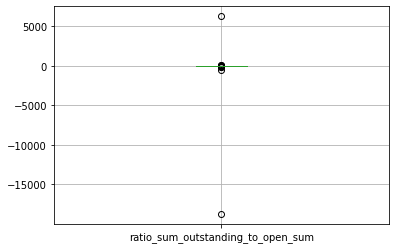

In [36]:
df.boxplot(column='ratio_sum_outstanding_to_open_sum');

В данных присутстсвут очень большие выбросы (аномалии), заменю выбросы "граничными" значениями -1 и 1 соответственно.

In [37]:
df.loc[df['ratio_sum_outstanding_to_open_sum'] >1, 'ratio_sum_outstanding_to_open_sum'] = 1

In [38]:
df.loc[df['ratio_sum_outstanding_to_open_sum'] <-1, 'ratio_sum_outstanding_to_open_sum'] = -1

In [39]:
df['ratio_sum_outstanding_to_open_sum'].describe()

count    42520.000000
mean         0.048318
std          0.268979
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.029894
max          1.000000
Name: ratio_sum_outstanding_to_open_sum, dtype: float64

**Вывод по обработке пропусков:**  
Пропуски были выявлены в 
- close_loan_median
- open_loan_median
- ratio_all_microloans_3_to_12
- ratio_overdue_loans_3_to_12
- ratio_history_12
- ratio_history_3
- ratio_history_1
- ratio_mean_delay_3_to_12
- ratio_pattern_len_to_pattern_1
- ratio_pattern_len_to_pattern_2
- ratio_pattern_len_to_pattern_3
- ratio_pattern_len_to_pattern_4
- ratio_pattern_len_to_pattern_bad_len
- ratio_sum_outstanding_to_open_sum

Предположу, что основная проблема появления пропусков это некорректный сбор данных, а именно отсутствие обработки деления на 0.  
В результате обработки пропусков к каждому столбцу нашлось обоснование причины замены пропуска на 0.  

## Исследовательский анализ данных

Выполним исследовательсий анализ, для этого для каждого столюца запустим функцию precheck, которая выведет основные характиристик столбца, распределение, количество уникальных значений, информацию о выбросах.

'--- Столбец Возраст заемщика ---'

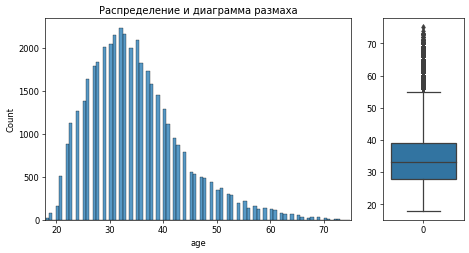

'Min = 18.0, Max = 75.0, Mean = 34.809666039510816, median = 39.0,  std = 8.822870827056839'

'Количество уникальных значений в столбце = 58'

'Количество выбросов: 1255'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (55.500) и меньше Q1 - 1.5*IQR (11.500).


'****************************'

'--- Столбец Время в днях, которое прошло с момента открытия последнего кредитного продукта ---'

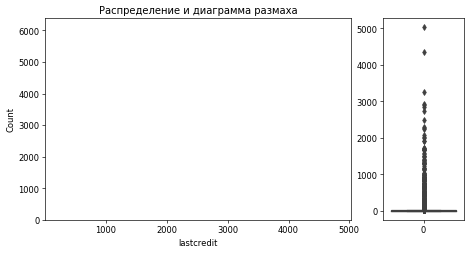

'Min = 1.0, Max = 5029.0, Mean = 10.578551269990593, median = 7.0,  std = 75.18038729172136'

'Количество уникальных значений в столбце = 379'

'Количество выбросов: 3158'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (14.500) и меньше Q1 - 1.5*IQR (-5.500).


'****************************'

'--- Столбец Время в днях, которое прошло с момента закрытия последнего микрокредита (если есть активные кредиты, эта переменная будет равна 0) ---'

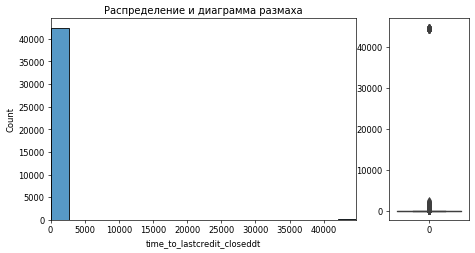

'Min = 0.0, Max = 44785.0, Mean = 117.77913922859831, median = 0.0,  std = 2252.458260169027'

'Количество уникальных значений в столбце = 396'

'Количество выбросов: 1846'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Медиана, взятая по количеству дней между закрытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между закрытием предыдущего и следующего микрокредита ---'

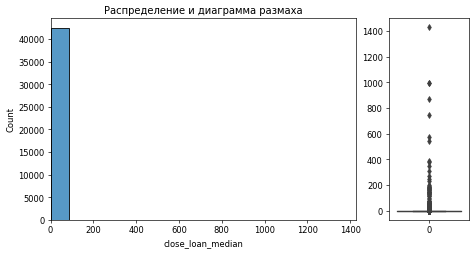

'Min = 0.0, Max = 1428.5, Mean = 0.3418156161806209, median = 0.0,  std = 13.084530298469732'

'Количество уникальных значений в столбце = 104'

'Количество выбросов: 361'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Медиана, взятая по количеству дней между открытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между открытием предыдущего и следующего микрокредита ---'

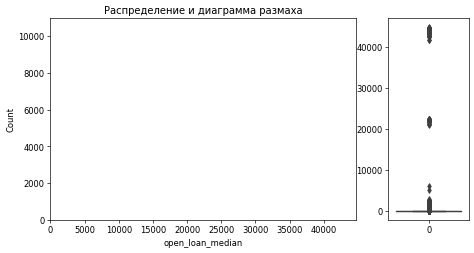

'Min = 0.0, Max = 44748.0, Mean = 208.410136406397, median = 4.0,  std = 2694.463251467268'

'Количество уникальных значений в столбце = 634'

'Количество выбросов: 5165'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (8.500) и меньше Q1 - 1.5*IQR (-3.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за все время ---'

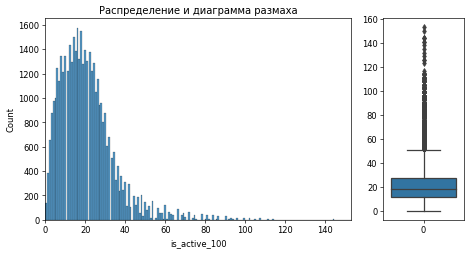

'Min = 0.0, Max = 153.0, Mean = 20.5178504233302, median = 27.0,  std = 14.09510360086602'

'Количество уникальных значений в столбце = 111'

'Количество выбросов: 1455'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (51.000) и меньше Q1 - 1.5*IQR (-13.000).


'****************************'

'--- Столбец Количество не возвращенных кредитов относительно всех кредитов, взятых за все время ---'

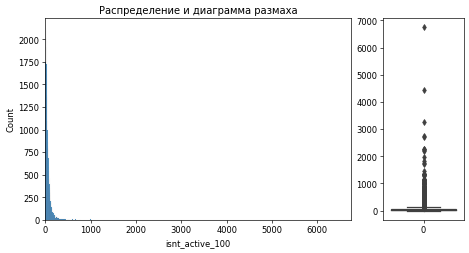

'Min = 0.0, Max = 6743.0, Mean = 59.138287864534334, median = 71.0,  std = 93.77687372362469'

'Количество уникальных значений в столбце = 629'

'Количество выбросов: 2863'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (152.000) и меньше Q1 - 1.5*IQR (-64.000).


'****************************'

'--- Столбец Невозвращенные кредиты, открытые за все время (например, переданные по цессии) ---'

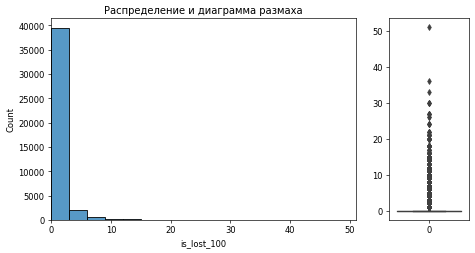

'Min = 0.0, Max = 51.0, Mean = 0.6012229539040451, median = 0.0,  std = 1.6779458160317338'

'Количество уникальных значений в столбце = 29'

'Количество выбросов: 10265'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Активная сумма микрокредитов, открытых за всё время ---'

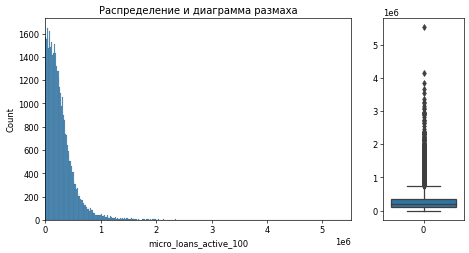

'Min = 0.0, Max = 5516940.0, Mean = 273306.47918626526, median = 364065.0,  std = 257209.45107243705'

'Количество уникальных значений в столбце = 34620'

'Количество выбросов: 1926'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (757344.375) и меньше Q1 - 1.5*IQR (-291400.625).


'****************************'

'--- Столбец Количество всех активных кредитов, открытых за последние 12 месяцев ---'

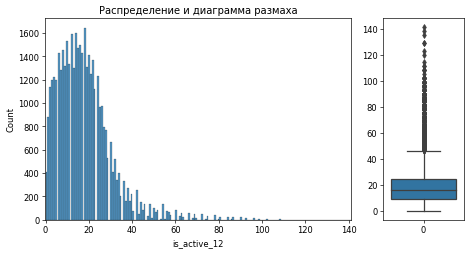

'Min = 0.0, Max = 141.0, Mean = 17.982079021636878, median = 24.0,  std = 12.962154879396541'

'Количество уникальных значений в столбце = 98'

'Количество выбросов: 1398'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (46.500) и меньше Q1 - 1.5*IQR (-13.500).


'****************************'

'--- Столбец Активная сумма кредитов, взятых за последние 12 месяцев ---'

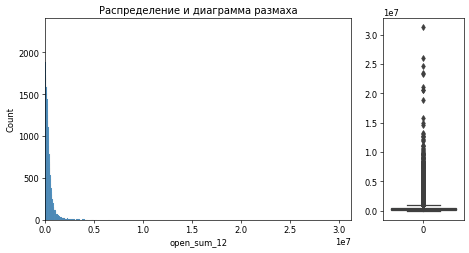

'Min = 0.0, Max = 31234690.0, Mean = 434155.5722953904, median = 490691.25,  std = 754687.4977063037'

'Количество уникальных значений в столбце = 36350'

'Количество выбросов: 3117'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (1043883.000) и меньше Q1 - 1.5*IQR (-431295.000).


'****************************'

'--- Столбец Количество закрытых кредитов, которые были открыты за последние 12 месяцев ---'

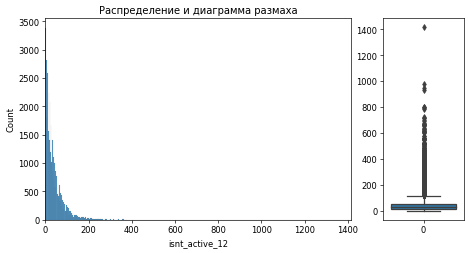

'Min = 0.0, Max = 1415.0, Mean = 41.25990122295391, median = 53.0,  std = 53.45345345571396'

'Количество уникальных значений в столбце = 442'

'Количество выбросов: 2696'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (117.500) и меньше Q1 - 1.5*IQR (-54.500).


'****************************'

'--- Столбец Невозвращенные кредиты, открытые за последние 12 месяцев ---'

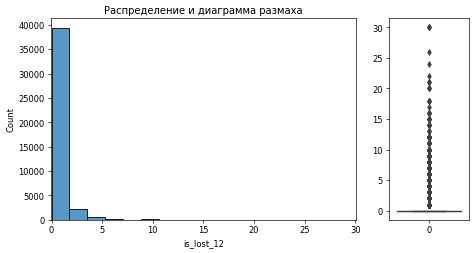

'Min = 0.0, Max = 30.0, Mean = 0.33384289746001883, median = 0.0,  std = 1.1268276657151515'

'Количество уникальных значений в столбце = 25'

'Количество выбросов: 6759'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество просроченных кредитов, открытых за последние 12 месяцев ---'

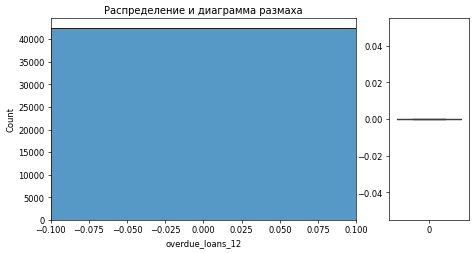

'Min = 0.0, Max = 0.0, Mean = 0.0, median = 0.0,  std = 0.0'

'Количество уникальных значений в столбце = 1'

0.0    42520
Name: overdue_loans_12, dtype: int64

'Количество выбросов: 0'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Активная сумма микрокредитов, открытых за последние 12 месяцев ---'

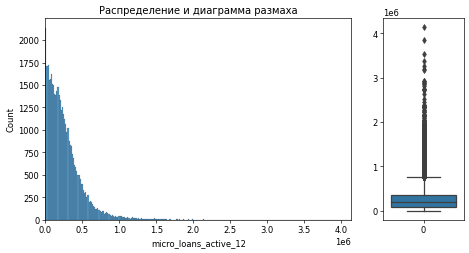

'Min = 0.0, Max = 4132170.0, Mean = 263074.22714016936, median = 355258.75,  std = 250247.84310976192'

'Количество уникальных значений в столбце = 34094'

'Количество выбросов: 1841'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (748463.125) и меньше Q1 - 1.5*IQR (-300081.875).


'****************************'

'--- Столбец Количество всех активных кредитов, открытых за последние 3 месяца ---'

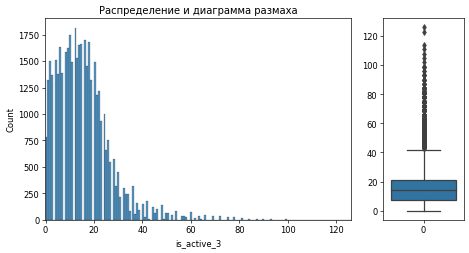

'Min = 0.0, Max = 126.0, Mean = 15.398189087488241, median = 21.0,  std = 11.370160048859104'

'Количество уникальных значений в столбце = 88'

'Количество выбросов: 1163'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (42.000) и меньше Q1 - 1.5*IQR (-14.000).


'****************************'

'--- Столбец Активная сумма кредитов, взятых за последние 3 месяца ---'

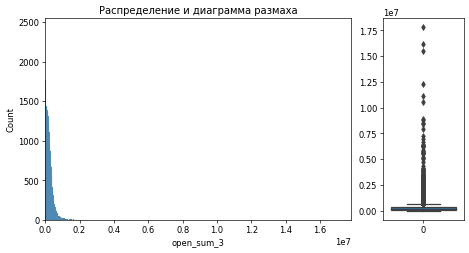

'Min = 0.0, Max = 17795090.0, Mean = 251763.0510112888, median = 326368.75,  std = 341829.25439118413'

'Количество уникальных значений в столбце = 33280'

'Количество выбросов: 1900'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (685421.875) и меньше Q1 - 1.5*IQR (-272053.125).


'****************************'

'--- Столбец Количество закрытых кредитов, которые были открыты за последние 3 месяца ---'

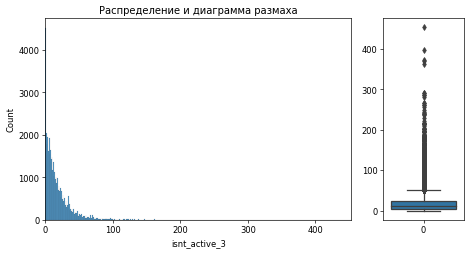

'Min = 0.0, Max = 453.0, Mean = 17.81194731890875, median = 23.0,  std = 21.24124274269004'

'Количество уникальных значений в столбце = 204'

'Количество выбросов: 2653'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (50.000) и меньше Q1 - 1.5*IQR (-22.000).


'****************************'

'--- Столбец Невозвращенные кредиты, открытые за последние 3 месяца ---'

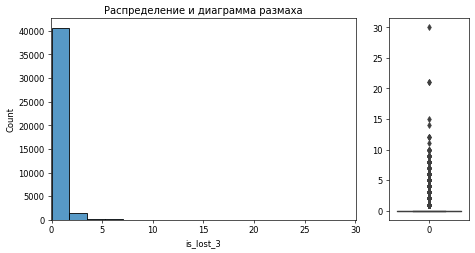

'Min = 0.0, Max = 30.0, Mean = 0.19661335841956726, median = 0.0,  std = 0.733598498222259'

'Количество уникальных значений в столбце = 17'

'Количество выбросов: 4750'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество просроченных кредитов, открытых за последние 3 месяца ---'

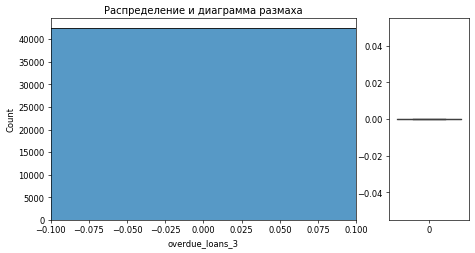

'Min = 0.0, Max = 0.0, Mean = 0.0, median = 0.0,  std = 0.0'

'Количество уникальных значений в столбце = 1'

0.0    42520
Name: overdue_loans_3, dtype: int64

'Количество выбросов: 0'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Активная сумма микрокредитов, открытых за последние 3 месяца ---'

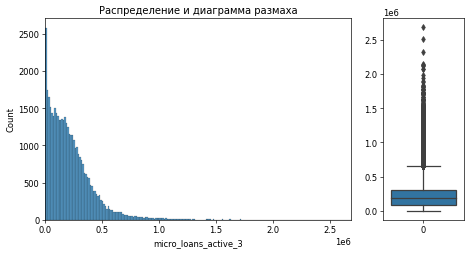

'Min = 0.0, Max = 2684358.0, Mean = 224470.8897460019, median = 308382.25,  std = 204271.6368458438'

'Количество уникальных значений в столбце = 32620'

'Количество выбросов: 1612'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (650108.500) и меньше Q1 - 1.5*IQR (-261161.500).


'****************************'

'--- Столбец Количество всех активных кредитов, открытых за последний месяц ---'

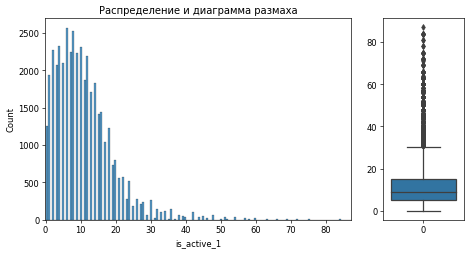

'Min = 0.0, Max = 87.0, Mean = 10.90994825964252, median = 15.0,  std = 8.589682349357625'

'Количество уникальных значений в столбце = 68'

'Количество выбросов: 1212'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (30.000) и меньше Q1 - 1.5*IQR (-10.000).


'****************************'

'--- Столбец Активная сумма кредитов, взятых за последний месяц ---'

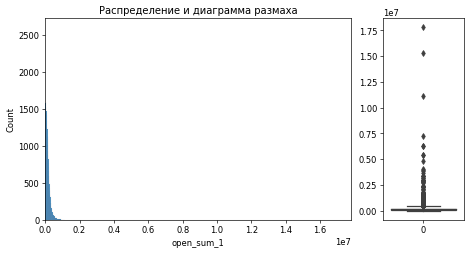

'Min = 0.0, Max = 17795090.0, Mean = 152438.53207902165, median = 201000.0,  std = 215250.64644784917'

'Количество уникальных значений в столбце = 27442'

'Количество выбросов: 1901'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (424920.750) и меньше Q1 - 1.5*IQR (-172201.250).


'****************************'

'--- Столбец Количество закрытых кредитов, которые были открыты за последний месяц ---'

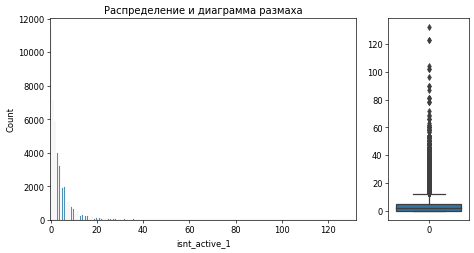

'Min = 0.0, Max = 132.0, Mean = 3.6568673565380996, median = 5.0,  std = 5.694917207834906'

'Количество уникальных значений в столбце = 73'

'Количество выбросов: 2299'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (12.500) и меньше Q1 - 1.5*IQR (-7.500).


'****************************'

'--- Столбец Невозвращенные кредиты, открытые за последний месяц (например, переданные по цессии) ---'

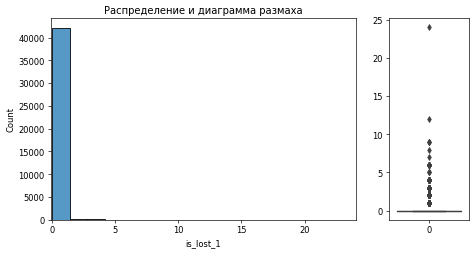

'Min = 0.0, Max = 24.0, Mean = 0.05009407337723424, median = 0.0,  std = 0.33631744614232656'

'Количество уникальных значений в столбце = 12'

'Количество выбросов: 1484'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Активная сумма микрокредитов, открытых за последний месяц ---'

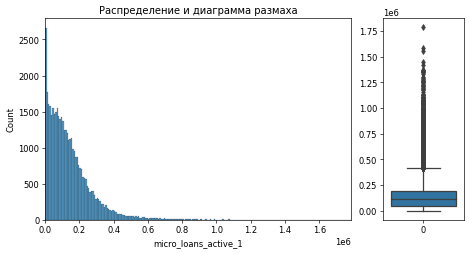

'Min = 0.0, Max = 1785204.0, Mean = 144504.49934148637, median = 196264.0,  std = 137131.5507641528'

'Количество уникальных значений в столбце = 27159'

'Количество выбросов: 1779'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (415480.000) и меньше Q1 - 1.5*IQR (-169096.000).


'****************************'

'--- Столбец Отношение количества микрокредитов, взятых за последние 3 месяца, к количеству микрокредитов, взятых за последние 12 месяцев ---'

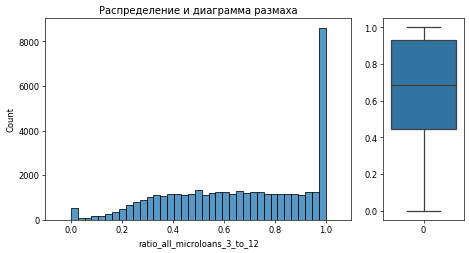

'Min = 0.0, Max = 1.0, Mean = 0.6641240938303805, median = 0.9285714285714286,  std = 0.2708784425958597'

'Количество уникальных значений в столбце = 6852'

'Количество выбросов: 0'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (1.652) и меньше Q1 - 1.5*IQR (-0.277).


'****************************'

'--- Столбец Отношение количества просроченных микрокредитов, взятых за последние 3 месяца, к количеству просроченных микрокредитов, взятых за последние 12 месяцев ---'

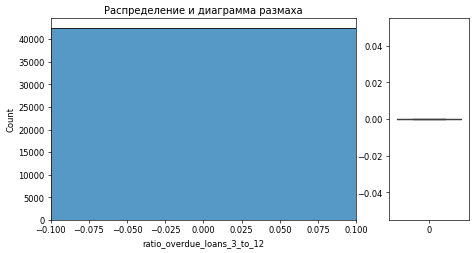

'Min = 0.0, Max = 0.0, Mean = 0.0, median = 0.0,  std = 0.0'

'Количество уникальных значений в столбце = 1'

0.0    42520
Name: ratio_overdue_loans_3_to_12, dtype: int64

'Количество выбросов: 0'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Доля не возвращенных кредитов относительно всех кредитов, взятых за все время ---'

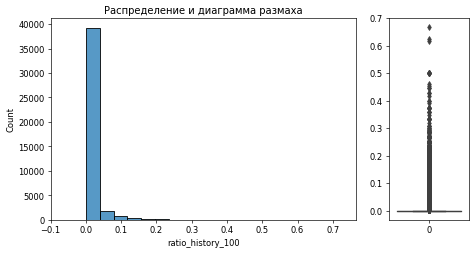

'Min = 0.0, Max = 0.6666666666666666, Mean = 0.010135104633260294, median = 0.0,  std = 0.03039218193130024'

'Количество уникальных значений в столбце = 1163'

'Количество выбросов: 10265'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 12 месяцев ---'

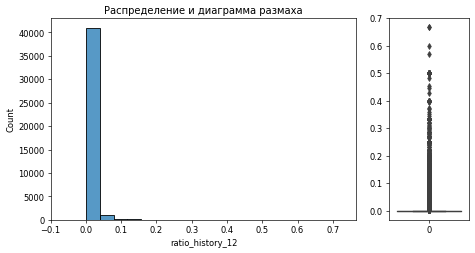

'Min = 0.0, Max = 0.6666666666666666, Mean = 0.0060346808639234065, median = 0.0,  std = 0.02658193334782243'

'Количество уникальных значений в столбце = 790'

'Количество выбросов: 6759'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Доля кредитов, взятых за последние 12 месяцев, относительно всех кредитов истории ---'

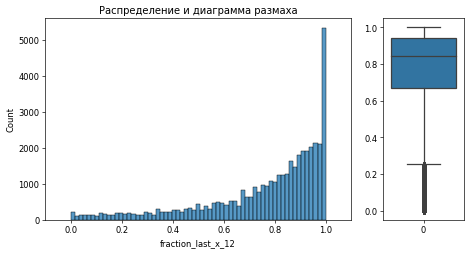

'Min = 0.0, Max = 1.0, Mean = 0.765257838116131, median = 0.944444444444444,  std = 0.2370813994446997'

'Количество уникальных значений в столбце = 7133'

'Количество выбросов: 2410'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (1.361) и меньше Q1 - 1.5*IQR (0.250).


'****************************'

'--- Столбец Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 3 месяца ---'

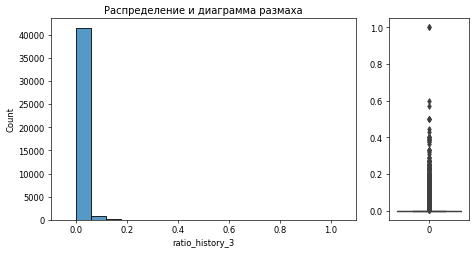

'Min = 0.0, Max = 1.0, Mean = 0.005432233353767782, median = 0.0,  std = 0.0226388616610531'

'Количество уникальных значений в столбце = 341'

'Количество выбросов: 4750'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Доля кредитов, взятых за последние 3 месяца, относительно всех кредитов истории ---'

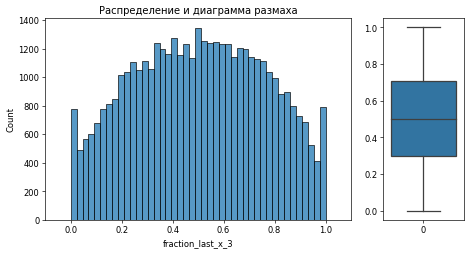

'Min = 0.0, Max = 1.0, Mean = 0.502330606649973, median = 0.7073170731707317,  std = 0.2572464920680622'

'Количество уникальных значений в столбце = 8239'

'Количество выбросов: 0'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (1.322) и меньше Q1 - 1.5*IQR (-0.318).


'****************************'

'--- Столбец Доля не возвращенных кредитов относительно всех кредитов, взятых за последний месяц ---'

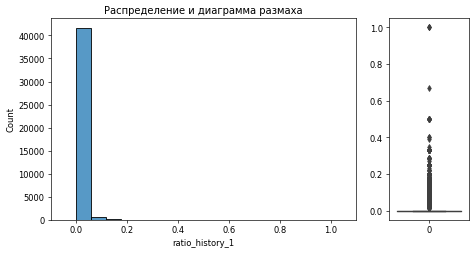

'Min = 0.0, Max = 1.0, Mean = 0.0031802931160274436, median = 0.0,  std = 0.022601657607793615'

'Количество уникальных значений в столбце = 102'

'Количество выбросов: 1484'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Доля кредитов, взятых за последний месяц, относительно всех кредитов истории ---'

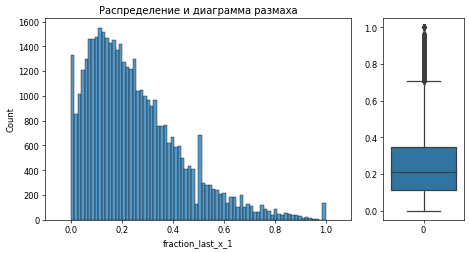

'Min = 0.0, Max = 1.0, Mean = 0.25137058289622677, median = 0.35,  std = 0.18353585868682085'

'Количество уникальных значений в столбце = 5976'

'Количество выбросов: 1105'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.706) и меньше Q1 - 1.5*IQR (-0.244).


'****************************'

'--- Столбец Средняя просрочка за всё время (с лагом по времени в 2 месяца) ---'

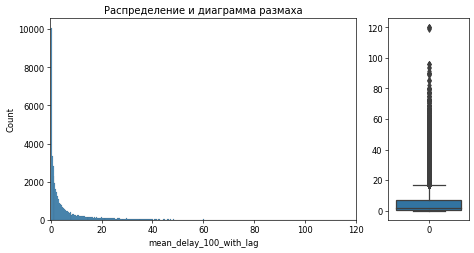

'Min = 0.0, Max = 120.0, Mean = 6.131995631666195, median = 6.9230769230769225,  std = 10.101080147367075'

'Количество уникальных значений в столбце = 19781'

'Количество выбросов: 4781'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (16.659) и меньше Q1 - 1.5*IQR (-9.304).


'****************************'

'--- Столбец Средняя просрочка за последние 12 месяцев (с лагом по времени в 2 месяца) ---'

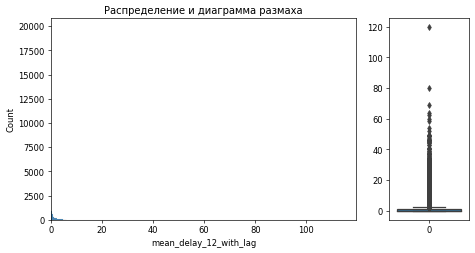

'Min = 0.0, Max = 119.5, Mean = 1.259656674095371, median = 1.0,  std = 3.3766261652842062'

'Количество уникальных значений в столбце = 10250'

'Количество выбросов: 5488'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (2.500) и меньше Q1 - 1.5*IQR (-1.500).


'****************************'

'--- Столбец Средняя просрочка за последние 3 месяца (с лагом по времени в 2 месяца) ---'

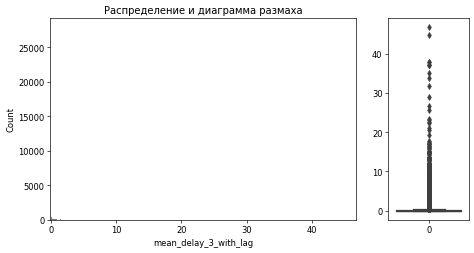

'Min = 0.0, Max = 46.73684210526321, Mean = 0.36016564218501274, median = 0.2105263157894736,  std = 1.2403319466778404'

'Количество уникальных значений в столбце = 5988'

'Количество выбросов: 6981'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.526) и меньше Q1 - 1.5*IQR (-0.316).


'****************************'

'--- Столбец Средняя просрочка за последний месяц (с лагом по времени в 2 месяца) ---'

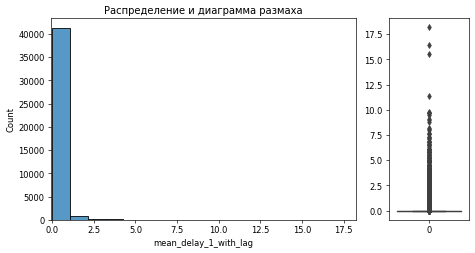

'Min = 0.0, Max = 18.166666666666668, Mean = 0.12114240469238545, median = 0.0,  std = 0.4642983856581203'

'Количество уникальных значений в столбце = 3296'

'Количество выбросов: 9163'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Отношение средней просрочки за последние 3 месяца к средней просрочке за последние 12 месяцев (в днях, с лагом по времени в 2 месяца) ---'

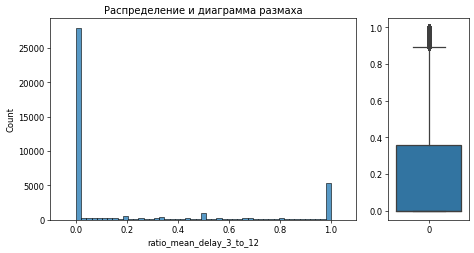

'Min = 0.0, Max = 1.0, Mean = 0.2211868533114445, median = 0.3564356435643564,  std = 0.3644492561458759'

'Количество уникальных значений в столбце = 4353'

'Количество выбросов: 5748'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.891) и меньше Q1 - 1.5*IQR (-0.535).


'****************************'

'--- Столбец Количество всех кредитов в истории ---'

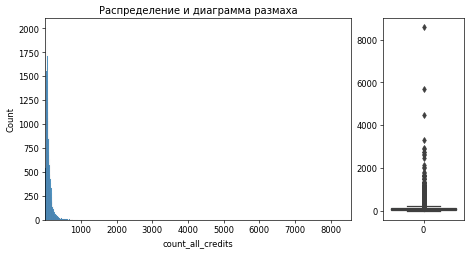

'Min = 1.0, Max = 8577.0, Mean = 96.09381467544685, median = 116.0,  std = 120.40790354865632'

'Количество уникальных значений в столбце = 752'

'Количество выбросов: 2625'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (230.000) и меньше Q1 - 1.5*IQR (-74.000).


'****************************'

'--- Столбец Отношение количества платежей в платежном паттерне к общему количеству запланированных платежей на данный момент ---'

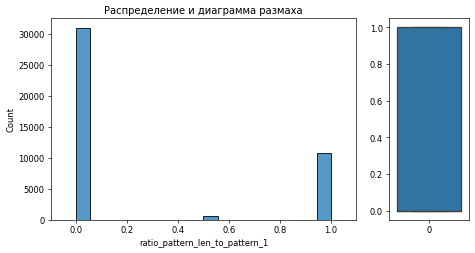

'Min = 0.0, Max = 1.0, Mean = 0.2615568243563204, median = 1.0,  std = 0.4340418717275307'

'Количество уникальных значений в столбце = 49'

'Количество выбросов: 0'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (2.500) и меньше Q1 - 1.5*IQR (-1.500).


'****************************'

'--- Столбец Отношение количества просрочек в 0:5 дней в платежном паттерне к общему количеству запланированных платежей на данный момент ---'

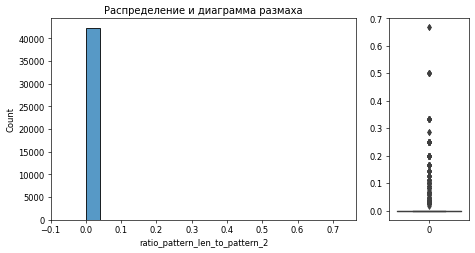

'Min = 0.0, Max = 0.666666666666667, Mean = 0.0007999268777670347, median = 0.0,  std = 0.0143388358326279'

'Количество уникальных значений в столбце = 46'

'Количество выбросов: 192'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Отношение количества просрочек в 6:30 дней в платежном паттерне к общему количеству запланированных платежей на данный момент ---'

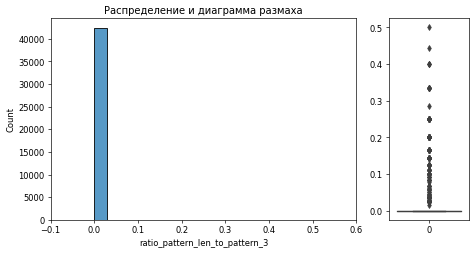

'Min = 0.0, Max = 0.5, Mean = 0.000562285191021989, median = 0.0,  std = 0.01084878547834021'

'Количество уникальных значений в столбце = 43'

'Количество выбросов: 158'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Отношение количества просрочек в 31:60 дней в платежном паттерне к общему количеству запланированных платежей на данный момент ---'

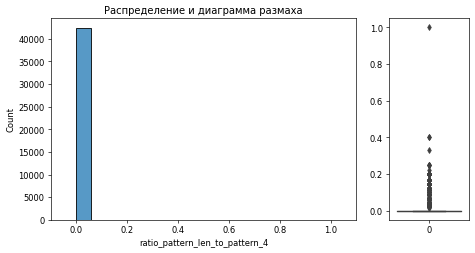

'Min = 0.0, Max = 1.0, Mean = 0.000423688262270007, median = 0.0,  std = 0.009543383856350554'

'Количество уникальных значений в столбце = 44'

'Количество выбросов: 136'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Отношение количества символов сильной просрочки (> 60 дней) в платежном паттерне к общему количеству символов в строке ---'

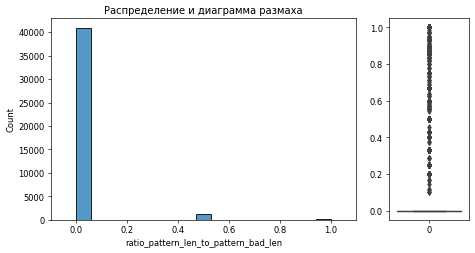

'Min = 0.0, Max = 1.0, Mean = 0.020464378739759922, median = 0.0,  std = 0.1088925713606843'

'Количество уникальных значений в столбце = 79'

'Количество выбросов: 1595'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Время в днях, которое прошло с момента открытия последнего микрокредита ---'

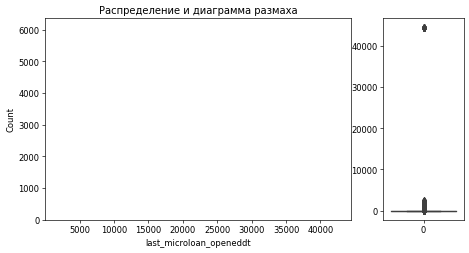

'Min = 1.0, Max = 44470.0, Mean = 71.27808090310442, median = 7.0,  std = 1638.1754139136478'

'Количество уникальных значений в столбце = 441'

'Количество выбросов: 3216'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (14.500) и меньше Q1 - 1.5*IQR (-5.500).


'****************************'

'--- Столбец Количество кредитов типа кредитная карта, открытых за всё время ---'

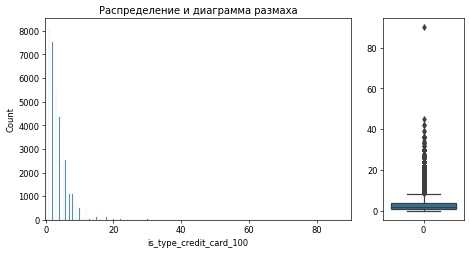

'Min = 0.0, Max = 90.0, Mean = 3.1264816556914394, median = 4.0,  std = 3.360193462755716'

'Количество уникальных значений в столбце = 36'

'Количество выбросов: 2598'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (8.500) и меньше Q1 - 1.5*IQR (-3.500).


'****************************'

'--- Столбец Количество кредитов типа потребительский кредит, открытых за всё время ---'

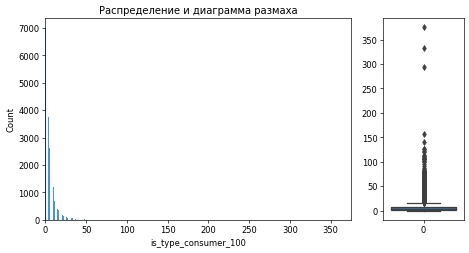

'Min = 0.0, Max = 375.0, Mean = 5.4358889934148635, median = 7.0,  std = 7.6702441300829705'

'Количество уникальных значений в столбце = 98'

'Количество выбросов: 2359'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (16.000) и меньше Q1 - 1.5*IQR (-8.000).


'****************************'

'--- Столбец Количество кредитов типа микрокредит, открытых за всё время ---'

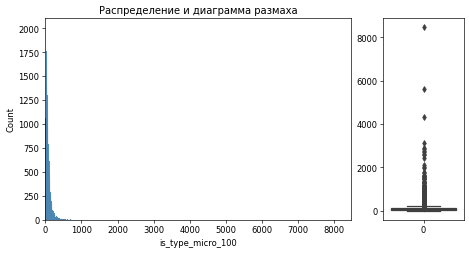

'Min = 0.0, Max = 8463.0, Mean = 85.10134054562559, median = 104.0,  std = 116.72676377545243'

'Количество уникальных значений в столбце = 748'

'Количество выбросов: 2606'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (213.500) и меньше Q1 - 1.5*IQR (-78.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за всё время с типом займа  кредитная карта ---'

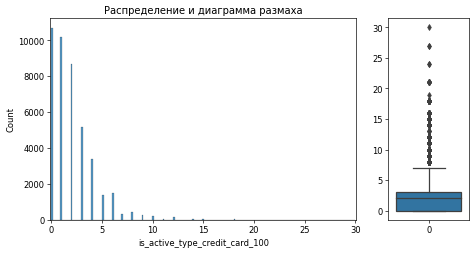

'Min = 0.0, Max = 30.0, Mean = 2.0486359360301036, median = 3.0,  std = 2.212044309862428'

'Количество уникальных значений в столбце = 23'

'Количество выбросов: 1228'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (7.500) и меньше Q1 - 1.5*IQR (-4.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за всё время с типом займа  потребительский кредит ---'

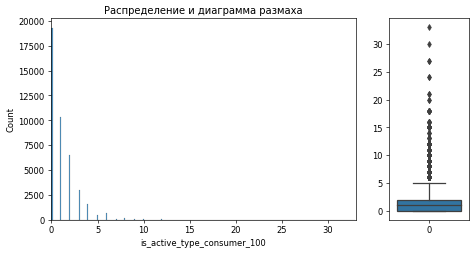

'Min = 0.0, Max = 33.0, Mean = 1.192662276575729, median = 2.0,  std = 1.703591834246292'

'Количество уникальных значений в столбце = 24'

'Количество выбросов: 1245'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (5.000) и меньше Q1 - 1.5*IQR (-3.000).


'****************************'

'--- Столбец Количество активных кредитов, открытых за все время с типом займа  микрокредит ---'

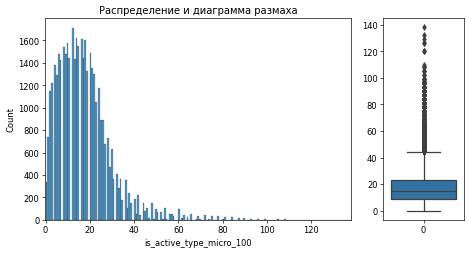

'Min = 0.0, Max = 138.0, Mean = 17.230997177798685, median = 23.0,  std = 12.26721305893061'

'Количество уникальных значений в столбце = 94'

'Количество выбросов: 1369'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (44.000) и меньше Q1 - 1.5*IQR (-12.000).


'****************************'

'--- Столбец Количество кредитов типа кредитная карта, открытых за последние 12 месяцев ---'

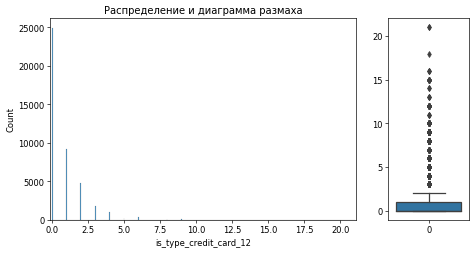

'Min = 0.0, Max = 21.0, Mean = 0.7928033866415805, median = 1.0,  std = 1.3269615192409452'

'Количество уникальных значений в столбце = 19'

'Количество выбросов: 3630'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (2.500) и меньше Q1 - 1.5*IQR (-1.500).


'****************************'

'--- Столбец Количество кредитов типа потребительский кредит, открытых за последние 12 месяцев ---'

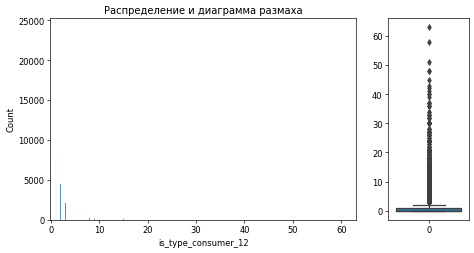

'Min = 0.0, Max = 63.0, Mean = 1.16846190028222, median = 1.0,  std = 2.459332235634346'

'Количество уникальных значений в столбце = 45'

'Количество выбросов: 5912'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (2.500) и меньше Q1 - 1.5*IQR (-1.500).


'****************************'

'--- Столбец Количество кредитов типа микрокредит, открытых за последние 12 месяцев ---'

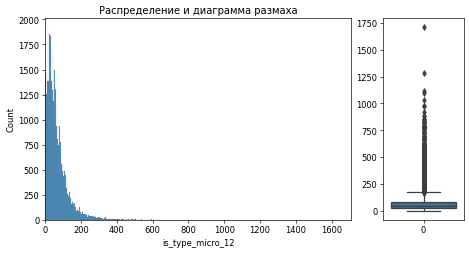

'Min = 0.0, Max = 1709.0, Mean = 66.46836782690498, median = 85.0,  std = 70.28056975956683'

'Количество уникальных значений в столбце = 544'

'Количество выбросов: 2444'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (176.500) и меньше Q1 - 1.5*IQR (-67.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 12 месяцев с типом займа  кредитная карта ---'

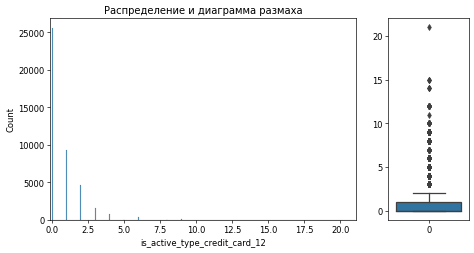

'Min = 0.0, Max = 21.0, Mean = 0.7175211665098777, median = 1.0,  std = 1.1999097107990853'

'Количество уникальных значений в столбце = 16'

'Количество выбросов: 3026'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (2.500) и меньше Q1 - 1.5*IQR (-1.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 12 месяцев с типом займа  потребительский кредит ---'

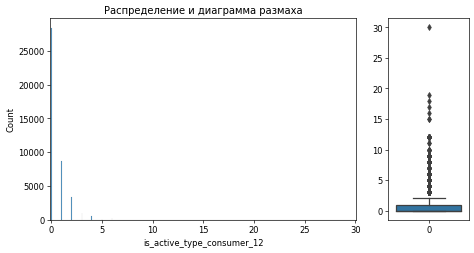

'Min = 0.0, Max = 30.0, Mean = 0.5575964252116651, median = 1.0,  std = 1.0744411658497002'

'Количество уникальных значений в столбце = 19'

'Количество выбросов: 2005'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (2.500) и меньше Q1 - 1.5*IQR (-1.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 12 месяцев с типом займа  микрокредит ---'

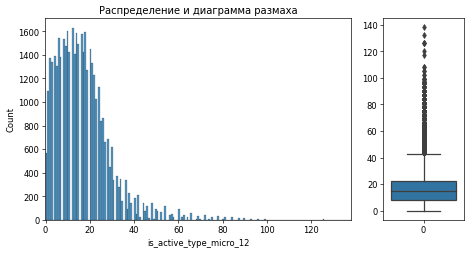

'Min = 0.0, Max = 138.0, Mean = 16.69374412041392, median = 22.0,  std = 12.302518392320508'

'Количество уникальных значений в столбце = 91'

'Количество выбросов: 1468'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (43.000) и меньше Q1 - 1.5*IQR (-13.000).


'****************************'

'--- Столбец Количество кредитов типа кредитная карта, открытых за последние 3 месяца ---'

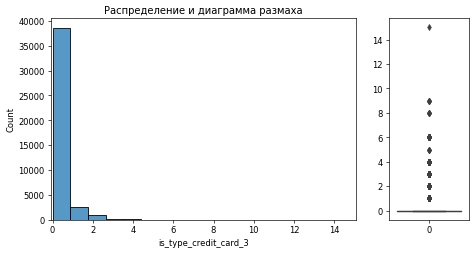

'Min = 0.0, Max = 15.0, Mean = 0.1385700846660395, median = 0.0,  std = 0.5230307020559916'

'Количество уникальных значений в столбце = 10'

'Количество выбросов: 3941'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество кредитов типа потребительский кредит , открытых за последние 3 месяца ---'

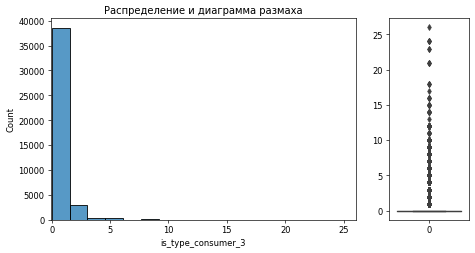

'Min = 0.0, Max = 26.0, Mean = 0.41246472248353716, median = 0.0,  std = 1.1812623503293622'

'Количество уникальных значений в столбце = 23'

'Количество выбросов: 8608'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество кредитов типа микрокредит, открытых за последние 3 месяца ---'

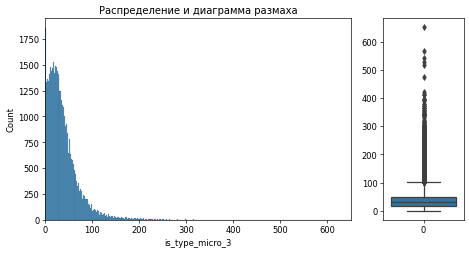

'Min = 0.0, Max = 651.0, Mean = 38.02920978363123, median = 50.0,  std = 35.3695065353629'

'Количество уникальных значений в столбце = 299'

'Количество выбросов: 1997'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (102.500) и меньше Q1 - 1.5*IQR (-37.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 3 месяца с типом займа  кредитная карта ---'

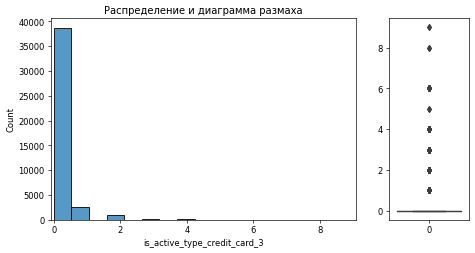

'Min = 0.0, Max = 9.0, Mean = 0.13278457196613358, median = 0.0,  std = 0.5010935689573975'

'Количество уникальных значений в столбце = 9'

'Количество выбросов: 3841'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 3 месяца с типом займа  потребительский кредит ---'

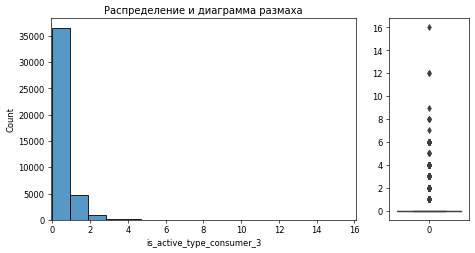

'Min = 0.0, Max = 16.0, Mean = 0.18675917215428034, median = 0.0,  std = 0.544152216654974'

'Количество уникальных значений в столбце = 12'

'Количество выбросов: 6019'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 3 месяца с типом займа  микрокредит ---'

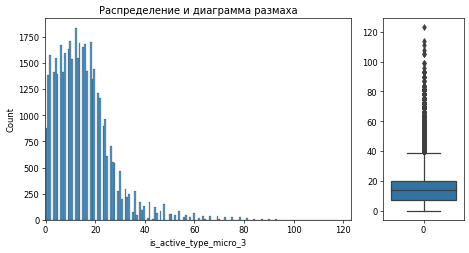

'Min = 0.0, Max = 123.0, Mean = 15.07596425211665, median = 20.0,  std = 11.20466844737285'

'Количество уникальных значений в столбце = 83'

'Количество выбросов: 1428'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (39.500) и меньше Q1 - 1.5*IQR (-12.500).


'****************************'

'--- Столбец Количество кредитов типа кредитная карта, открытых за последние 12 месяцев ---'

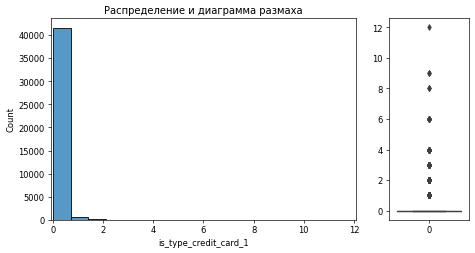

'Min = 0.0, Max = 12.0, Mean = 0.03229068673565381, median = 0.0,  std = 0.2598362427523387'

'Количество уникальных значений в столбце = 9'

'Количество выбросов: 943'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество кредитов типа потребительский кредит, открытых за последний месяц ---'

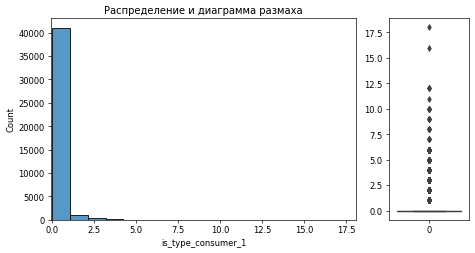

'Min = 0.0, Max = 18.0, Mean = 0.17029633113828788, median = 0.0,  std = 0.600843035810892'

'Количество уникальных значений в столбце = 15'

'Количество выбросов: 4774'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество кредитов типа микрокредит, открытых за последний месяц ---'

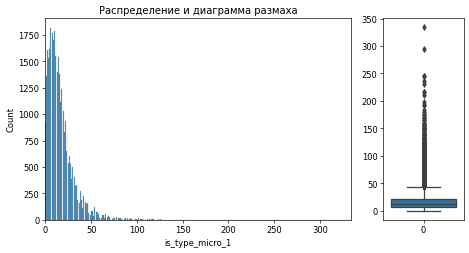

'Min = 0.0, Max = 334.0, Mean = 16.74821260583255, median = 22.0,  std = 15.944969898278426'

'Количество уникальных значений в столбце = 154'

'Количество выбросов: 2177'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (44.500) и меньше Q1 - 1.5*IQR (-15.500).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последние 12 месяцев с типом займа  кредитная карта ---'

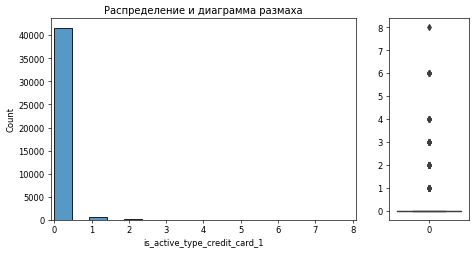

'Min = 0.0, Max = 8.0, Mean = 0.031396989651928504, median = 0.0,  std = 0.2481894275118716'

'Количество уникальных значений в столбце = 7'

'Количество выбросов: 927'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последний 1 месяц с типом займа  потребительский кредит ---'

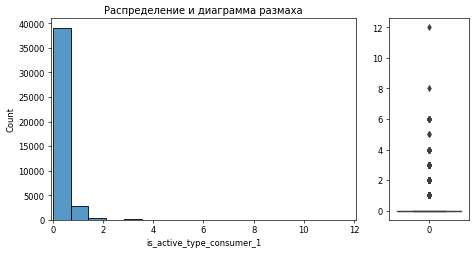

'Min = 0.0, Max = 12.0, Mean = 0.09945907808090311, median = 0.0,  std = 0.3807618661830976'

'Количество уникальных значений в столбце = 9'

'Количество выбросов: 3429'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.000) и меньше Q1 - 1.5*IQR (0.000).


'****************************'

'--- Столбец Количество активных кредитов, открытых за последний 1 месяц с типом займа  микрокредит ---'

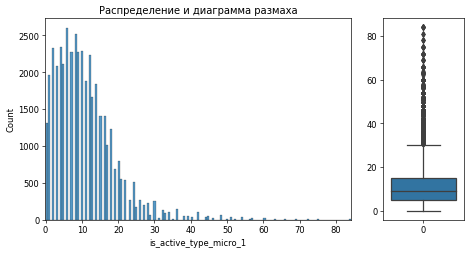

'Min = 0.0, Max = 84.0, Mean = 10.77810442144873, median = 15.0,  std = 8.509175255545792'

'Количество уникальных значений в столбце = 66'

'Количество выбросов: 1176'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (30.000) и меньше Q1 - 1.5*IQR (-10.000).


'****************************'

'--- Столбец Максимальное количество дней просрочки по кредиту ---'

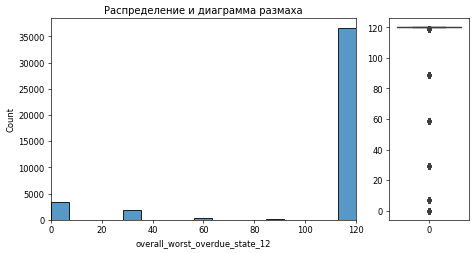

'Min = 0.0, Max = 120.0, Mean = 105.66987300094074, median = 120.0,  std = 36.602760271397266'

'Количество уникальных значений в столбце = 7'

'Количество выбросов: 5994'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (120.000) и меньше Q1 - 1.5*IQR (120.000).


'****************************'

'--- Столбец Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю ---'

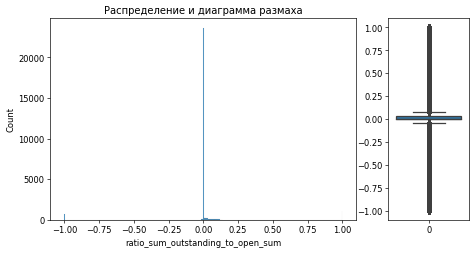

'Min = -1.0, Max = 1.0, Mean = 0.04831755210899425, median = 0.029893924069981502,  std = 0.26897928836669965'

'Количество уникальных значений в столбце = 16937'

'Количество выбросов: 10684'

Обратитить внимание на данные в столбце , значения 
 которые больше Q3 + 1.5*IQR (0.075) и меньше Q1 - 1.5*IQR (-0.045).


'****************************'

CPU times: total: 47min 6s
Wall time: 50min 48s


In [40]:
%%time
for i in df.drop(['id','target'], axis=1).columns:
    precheck(df, i)

**ВЫВОД по исследовательскому анализу:**  
В результате исследовательского анализа сделал следующие наблюдения:

- Время в днях, которое прошло с момента открытия последнего кредитного продукта **(lastcredit)** - у большинства заемщиков менее 14,5. Т.е. клиенты получили кредит в последние 2 недели.  
- Время в днях, которое прошло с момента закрытия последнего микрокредита (если есть активные кредиты, эта переменная будет равна 0) **(time_to_lastcredit_closeddt)** - есть аномальное значение 44785 дня (122 года). Это либо выброс, либо столбец содержит дату = 12.08.2022. Нужно разбираться при сборе датасета что это за данные. Скорее всего у клиента не было закрытых кредитов ранее, поэтому получили «текущую дату».
- Время в днях, которое прошло с момента открытия последнего микрокредита **(last_microloan_openeddt)**. Максимальное - 44470.0 вероятнее всего из даты получения кредита вычли предыдущую дату, а ее нет, т.е. у клиента первый кредит. Получили «аномалию».


- Медиана, взятая по количеству дней между закрытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между закрытием предыдущего и следующего микрокредита **(close_loan_median)**- у большинства заемщиков данное значение 0, что может говорить о том, что такие заемщики берут новый кредит еще не закрыв старый. Это означает закредитованность портфеля.
- Медиана, взятая по количеству дней между открытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между открытием предыдущего и следующего микрокредита **(open_loan_median)** - есть аномальное значение 44748 дней (122 года). Это либо выброс, либо столбец содержит дату = 06.07.2022. Нужно разбираться при сборе датасета что это за данные. Также медиана 4, а у большинства 8,5 дней проходит между открытием микрокредитов. Очень странные данные, не понятно что за кредиты. Скорее всего у клиента предыдущих кредитов ранее, поэтому получили «текущую дату».


- Количество не возвращенных кредитов относительно всех кредитов, взятых за все время **(isnt_active_100)**. Клиент с 6743 невозвращенными кредитами кажется очень странным. Медиана 71 невозвращенный кредит тоже выглядит очень странным при анализе данного портфеля.
-  Количество закрытых кредитов, которые были открыты за последние 12 месяцев **(isnt_active_12)** – Максимальное значение 1415 закрытых кредитов за год, это 4 закрытых кредита в день. Выглядит тоже очень странно.  
- Количество закрытых кредитов, которые были открыты за последние 3 месяца. Максимальное значение 453 кредита выглядит странно. Даже если предположить, что все кредиты у данного заемщика закрыты и не осталось активных, то это необходимо было получать по 5 кредитов в день. 
- Количество закрытых кредитов, которые были открыты за последний месяц **(isnt_active_1)**. Максимальное значение 132 кредита. Как и в предыдущем случае аномалия.  


- Количество просроченных кредитов, открытых за последние 12 месяцев **(overdue_loans_12)**. Весь столбец заполнен нулями. Скорее всего ошибка при сборе данных. Далее удалим данный столбец из данных при моделировании.
- Количество просроченных кредитов, открытых за последние 3 месяца **(overdue_loans_3)**. Весь столбец заполнен нулями. Скорее всего ошибка при сборе данных. Далее удалим данный столбец из данных при моделировании., особенно учитывая, что в столбце невозвращенные кредиты, открытые за последние 3 мес есть ненулевые данные.
- Отношение количества просроченных микрокредитов, взятых за последние 3 месяца, к количеству просроченных микрокредитов, взятых за последние 12 месяцев **(ratio_overdue_loans_3_to_12)**. Весь столбец заполнен нулями. Скорее всего ошибка при сборе данных. Далее удалим данный столбец из данных при моделировании.

- Количество всех активных кредитов, открытых за последние 3 месяца **(is_active_3)**. Максимальное значение 126 кредитов. Не понятно зачем брать 126 кредитов за последние 3 мес (более 1 кредита в день) при условии, что все до сих пор открытые. 
- Количество всех активных кредитов, открытых за последний месяц **(is_active_1)**. Максимальное значение 87 кредитов за месяц. Аномалия.  


-	Количество всех кредитов в истории **(count_all_credits)** – Максимальное значение 8577 – очень странный заемщик.  
Медианное 116 - у половины клиентов 116 кредитов и более кредитов за всю историю.  
-	Количество кредитов типа микрокредит, открытых за всё время **(is_type_micro_100)**. Максимальное значение 8463 – очень странный заемщик.  
Медианное 104 - у половины клиентов 104 кредитов и более кредитов за всю историю.  
- Количество кредитов типа микрокредит, открытых за последние 3 месяца **(is_type_micro_3)**. Максимум 651 микрокредит открыт заемщик.   Медиана 50 говорит о том, что половина заемщиков открыла 50 и более микрокредитов за последние 3 месяца.  
- Количество кредитов типа микрокредит, открытых за последний месяц **(is_type_micro_1)**. Максимум 334 микрокредит открыт заемщик.   Медиана 50 говорит о том, что половина заемщиков открыла 22 и более микрокредитов за последний месяц.  


- Максимальное количество дней просрочки по кредиту **(overall_worst_overdue_state_12)**. Максимум 120 дней. Странно, полагаю, что далее передают клиента на полное досрочное взыскание или перестают считать. Из графика видно, что практически все клиенты имели максимальное количество дней просрочки по кредиту 120 дней, т.е (если мы рассматриваем такое количество дней в рамках 1 договора – клиент уже признан банкротом, т.к. это происходит после 90 дня)



## Обработка выбросов и аномальных значений

В рамках обработки выбросов не буду заменять выбросы медианным значением, т.к. в большинстве признаков медианное значение равно 0. Также у них выбранные "границы" допустимых значений также равны 0.  
В таком случае данные признаки полнотстью "занулятся" и не будут нести никакой смысловой нагрузки для модели.

Заменять значения выбросов, превышающие третий квантиль буду значением третьего квантиля, увеличенного на 1.
Заменять значения выбросов, менее первого квантиля буду значением первого квантиля, уменьшенного на 1.

In [41]:
def replace_outlire(data, column):
    """Функция для обработки выбросов
    Заменять значения выбросов, превышающие третий квантиль, буду значением третьего квантиля, увеличенного на 1. 
    Заменять значения выбросов, менее первого квантиля, буду значением первого квантиля, уменьшенного на 1
    """
    
    """
    input :
    data : DataFrame
    columns : string


    output : 
    Столбец, в котором обработали выбросы
    """
    
    stats = data[column].describe()
    q_1 = stats[4]   # первый квантиль
    q_3 = stats[6]   # третий квантиль
    data.loc[(data[column] < q_1), column]= q_1 - 1   # значение первого квантиля, уменьшенное на 1
    data.loc[(data[column] > q_1), column]= q_3 + 1   # значение третьего квантиля, увеличенное на 1.


Для обработки выбросов буду использовать все столбцы, кроме:  
- id: не будет участвовать в обучении модели  
- age: считаю, что модель должна обучаться используя полностью данные из всего интервала признака
- fraction_last_x_12 : не увидел аномалий  
- overall_worst_overdue_state_12 : важный фактор, считаю, что нужно передавать в модель данные без удаления выбросов
- ratio_sum_outstanding_to_open_sum : уже предобработали
- target - целевой признак, нет выбросов  

In [42]:
columns_with_outlires = df.drop(['id', 
                                 'age', 
                                 'fraction_last_x_12', 
                                 'ratio_sum_outstanding_to_open_sum', 
                                 'overall_worst_overdue_state_12', 
                                 'target'], axis=1).columns
columns_with_outlires

Index(['lastcredit', 'time_to_lastcredit_closeddt', 'close_loan_median',
       'open_loan_median', 'is_active_100', 'isnt_active_100', 'is_lost_100',
       'micro_loans_active_100', 'is_active_12', 'open_sum_12',
       'isnt_active_12', 'is_lost_12', 'overdue_loans_12',
       'micro_loans_active_12', 'is_active_3', 'open_sum_3', 'isnt_active_3',
       'is_lost_3', 'overdue_loans_3', 'micro_loans_active_3', 'is_active_1',
       'open_sum_1', 'isnt_active_1', 'is_lost_1', 'micro_loans_active_1',
       'ratio_all_microloans_3_to_12', 'ratio_overdue_loans_3_to_12',
       'ratio_history_100', 'ratio_history_12', 'ratio_history_3',
       'fraction_last_x_3', 'ratio_history_1', 'fraction_last_x_1',
       'mean_delay_100_with_lag', 'mean_delay_12_with_lag',
       'mean_delay_3_with_lag', 'mean_delay_1_with_lag',
       'ratio_mean_delay_3_to_12', 'count_all_credits',
       'ratio_pattern_len_to_pattern_1', 'ratio_pattern_len_to_pattern_2',
       'ratio_pattern_len_to_pattern_3', '

In [43]:
for i in columns_with_outlires:
    replace_outlire(df, i)

## Проверка корелляции:

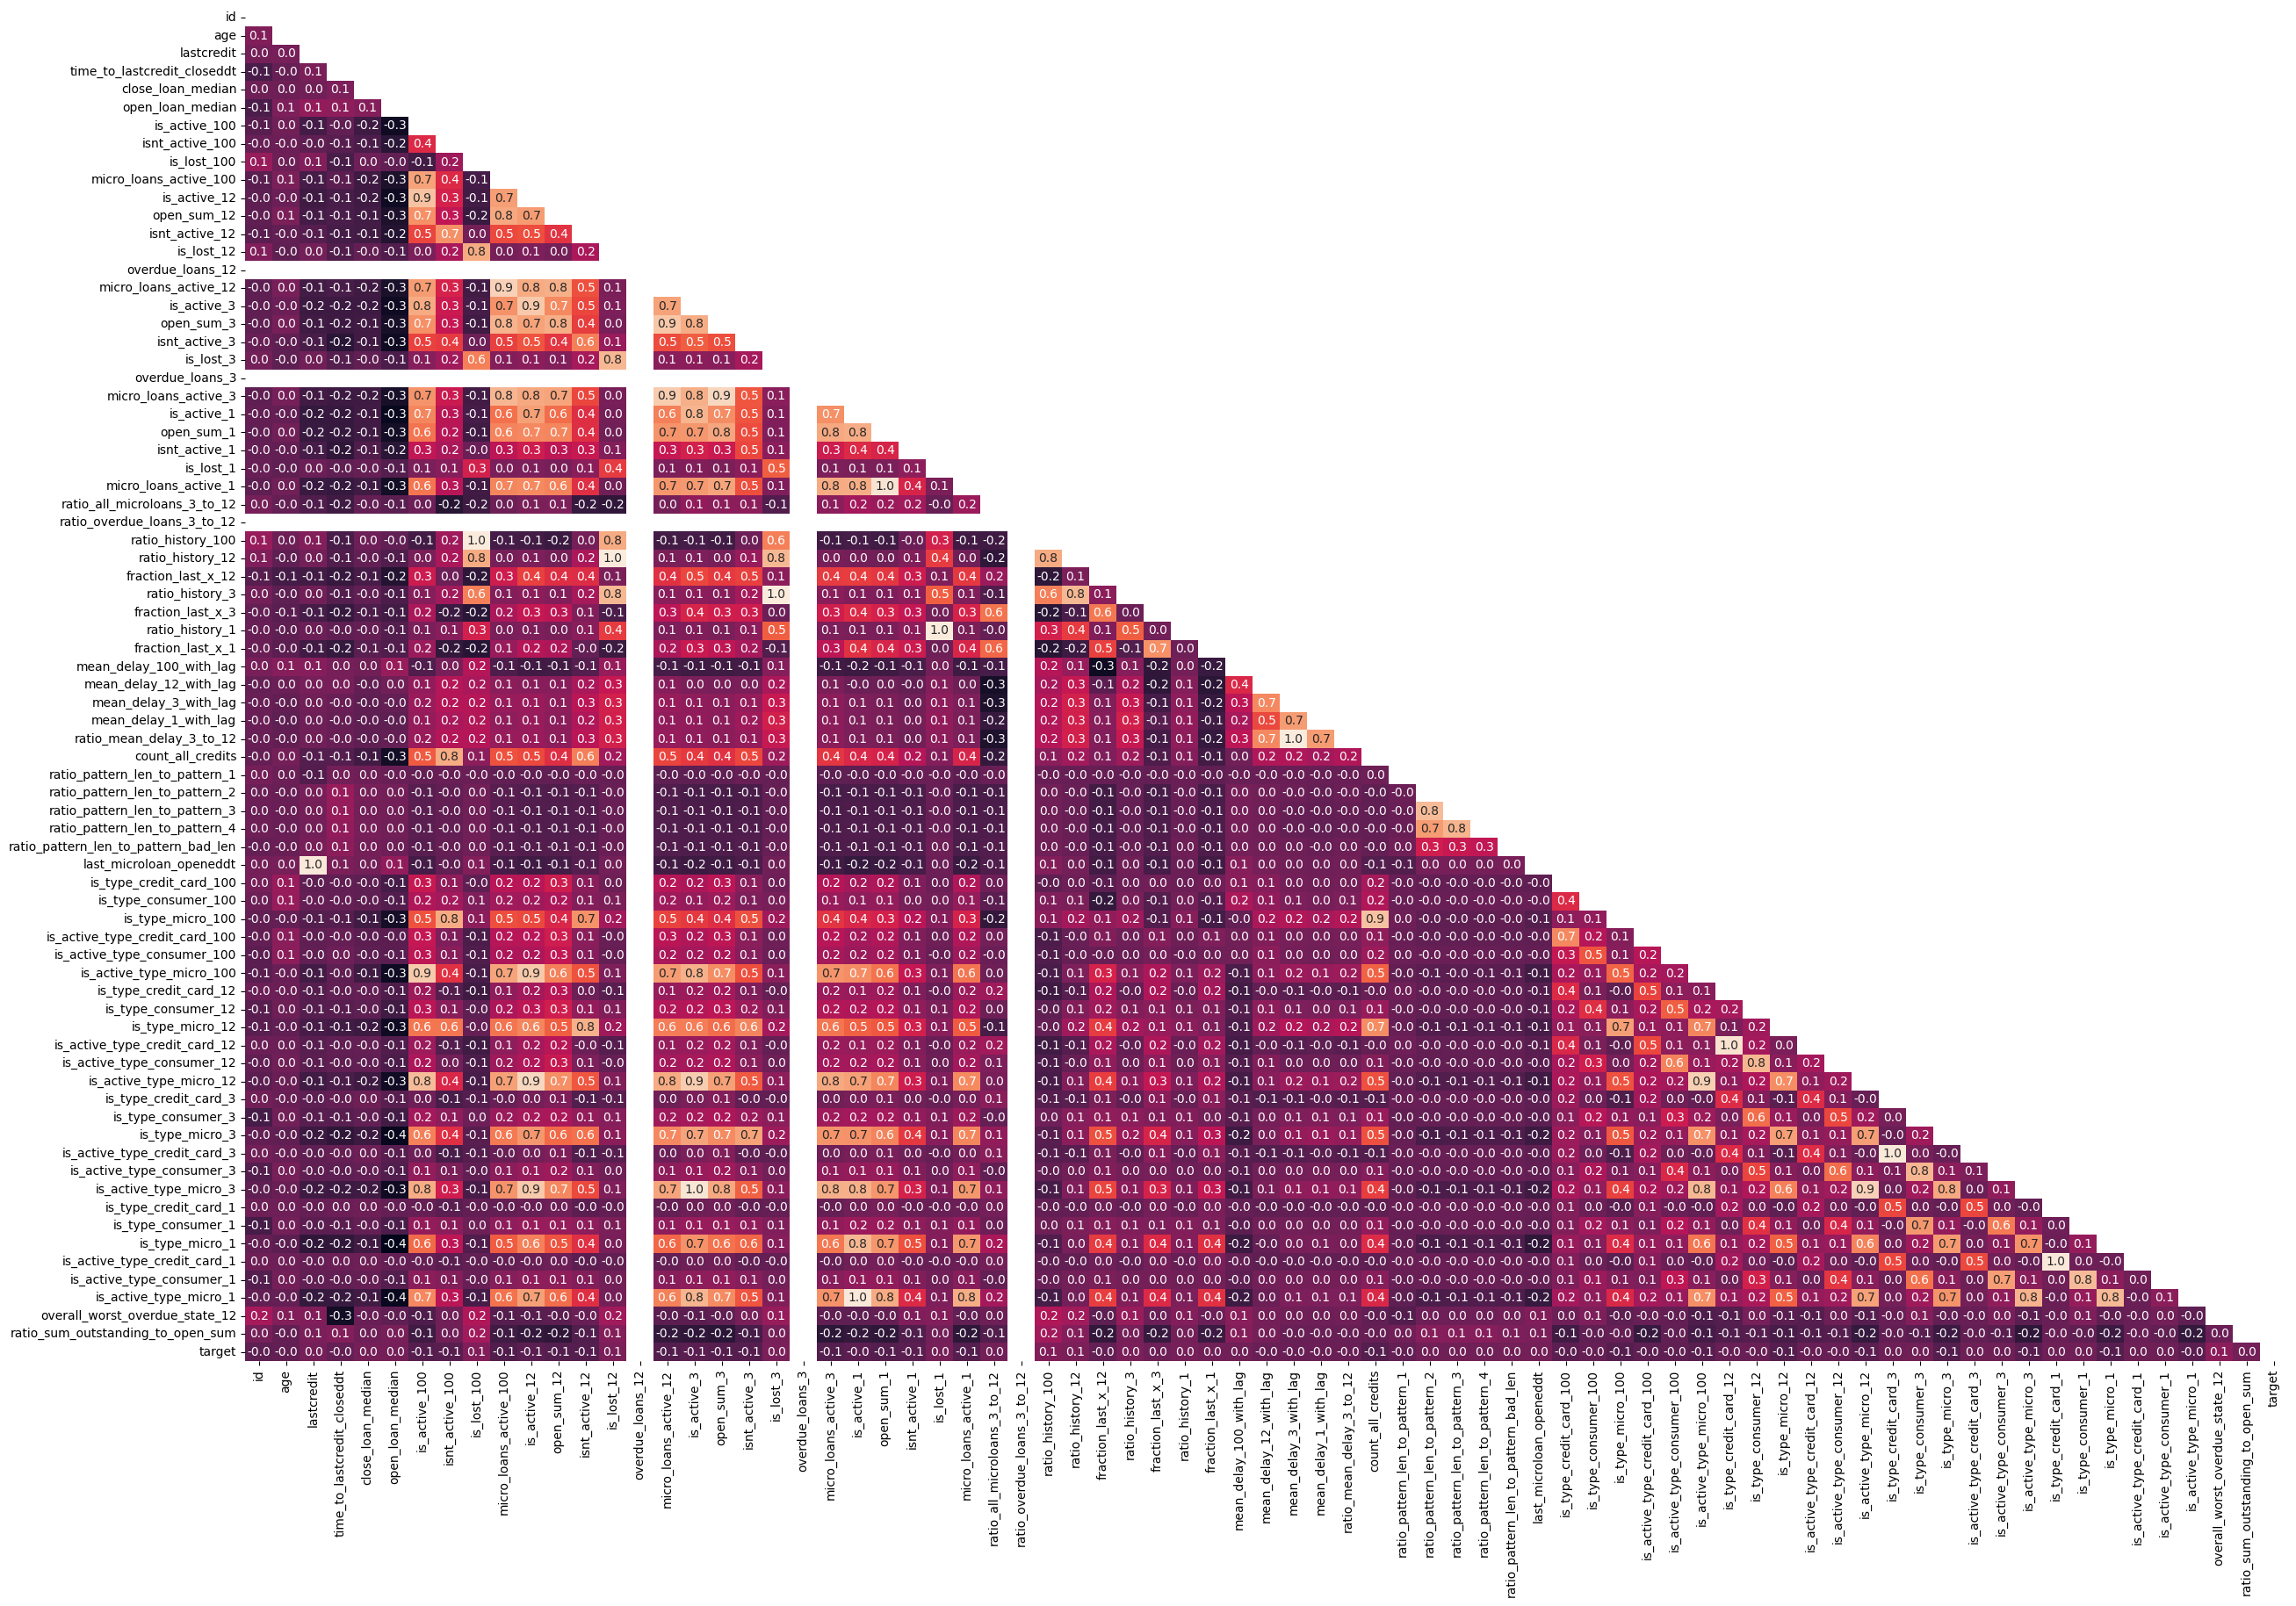

CPU times: total: 32.4 s
Wall time: 36.2 s


In [44]:
%%time
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(),annot=True,fmt="0.1f",cbar=False,mask=np.triu(df.corr()));
plt.show()

Из данной таблицы видим, что с целевым признаком не кореллирует ни один из имеющихся признаков.  
Есть корелляция признаков между собой, но это обусловливается одинаковыми параметрами взятыми за разные сроки.  
Удалять такие признаки на текущем этапе не буду

## Построим и проверим гипотезы о клинтском портфеле

Гипотезы:
- **Возраст "хороших" заемщиков больше по сравнению с "плохими"** (распределение возраста в зависимости от флага банкротства смещено в большую сторону);
- **Активная сумма кредитов** влияет на банкротство, чем больше у заемщика задолженность - больше вероятности стать банкротом;
- **Количество невозвращенных кредитов** влияет на банкротство, чем больше у заемщика невозвращенных кредитов - больше вероятности стать банкротом;
- **Доля невозращенных кредитов** влияет на банкротство - чем выше доля - тем больше вероятность просрочки. Имеет смысл посмотреть последние 12 месяцев (т.к. если смотреть весь период, то можно выявить негативные исторические события: мировые кризисы, потерю работы в прошлом и прочее);
- **Отношение суммы просрочки по всем кредитам к сумме взятых кредитов** - влияет на банкротство - чем выше доля - тем больше вероятность просрочки. 
- **Максимальное количество дней просрочки по кредиту** - влияет на банкротство - ниже количество дней - тем меньше вероятность банкротства.

### Гипотеза 1: Age
Возраст "хороших" заемщиков больше по сравнению с "плохими" (распределение возраста в зависимости от флага банкротства смещено в большую сторону)

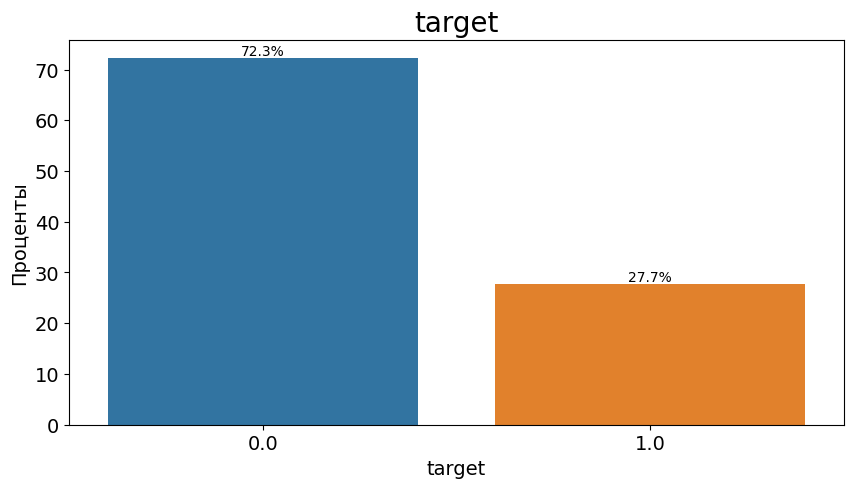

In [45]:
#Т.к. у нас дисбаланс классов - нормируем на размер датасета
norm_target = (df
               .target
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(10,5))
ax = sns.barplot(x='index', y='percent', data=norm_target)

#Вывод значений над графиком - annotate() 
#В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0,5),
                textcoords = 'offset points',
                fontsize=10)
    
plt.title('target', fontsize=20)

plt.xlabel('target', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

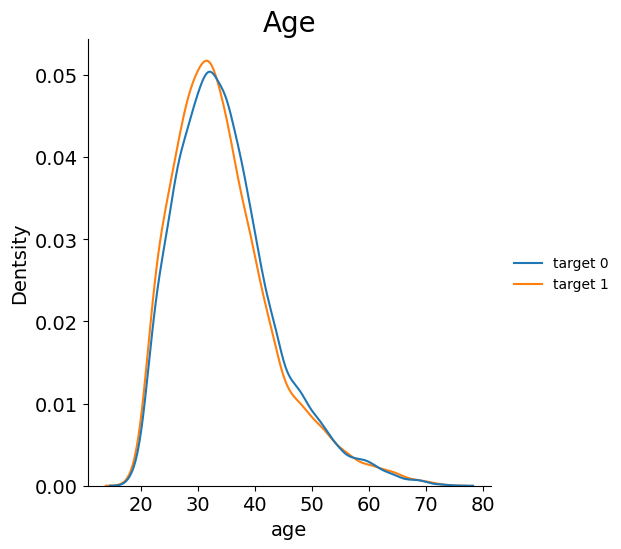

In [46]:
sns.displot(
    {
        "target 0" : df[df.target == 0].age,
        "target 1" : df[df.target == 1].age
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('Age', fontsize=20)

plt.xlabel('age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Посмотрим отличия в медианах по возрасту у "хороших" и "прохих" заемщиков

In [47]:
df.groupby('target')['age'].median()

target
0.0    34.0
1.0    33.0
Name: age, dtype: float64

Посмотрим отличия в среднем по возрасту у "хороших" и "прохих" замещиков

In [48]:
df.groupby('target')['age'].mean()

target
0.0    34.967386
1.0    34.398915
Name: age, dtype: float64

Посмотрим отличия в модах по возрасту у "хороших" и "прохих" заемщиков

In [49]:
df.groupby('target')['age'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,age
0,0.0,32.0
1,1.0,32.0


**Вывод** по анализу гипотезы о том, что возраст "хорощих" заемщиков больше по сравнению с "плохими":  
Средний возраст у "хороших" на 1 год выше чем у "плохих".  
Медиана и мода практически не отличаются.  

Таким образом гипотеза о том, что возраст "хороших" заемщиков выше неверна

### Гипотеза 2: Open_sum
Активная сумма кредитов влияет на банкротство: чем больше у заемщика задолженность - больше вероятности стать банкротом;

Активная сумма кредитов, взятых за последние 12 месяцев:

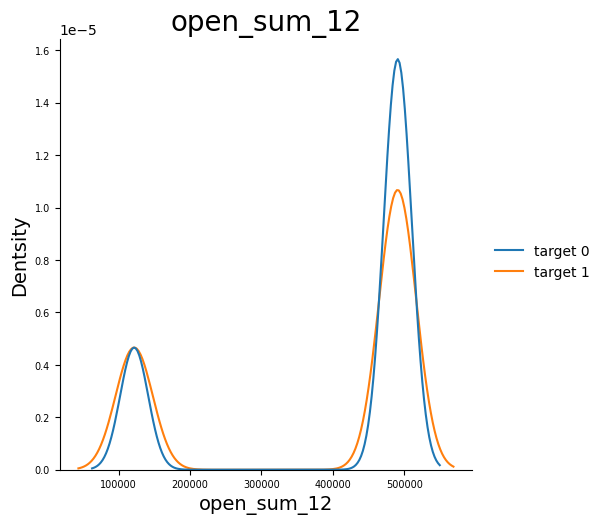

In [50]:
sns.displot(
    {
        "target 0" : df[df.target == 0].open_sum_12,
        "target 1" : df[df.target == 1].open_sum_12
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('open_sum_12', fontsize=20)

plt.xlabel('open_sum_12', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

Посмотрим отличия в медианах по активной сумме кредитов за последние 12 мес у "хороших" и "прохих" заемщиков

In [51]:
df.groupby('target')['open_sum_12'].median()

target
0.0    490692.25
1.0    490692.25
Name: open_sum_12, dtype: float64

Посмотрим отличия в средних по активной сумме кредитов за последние 12 мес у "хороших" и "прохих" заемщиков

In [52]:
df.groupby('target')['open_sum_12'].mean()

target
0.0    406136.622425
1.0    378587.117424
Name: open_sum_12, dtype: float64

Посмотрим отличия в модах по активной сумме кредитов за последние 12 мес у "хороших" и "прохих" заемщиков

In [53]:
df.groupby('target')['open_sum_12'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,open_sum_12
0,0.0,490692.25
1,1.0,490692.25


Активная сумма микрокредитов за последние 12 месяцев

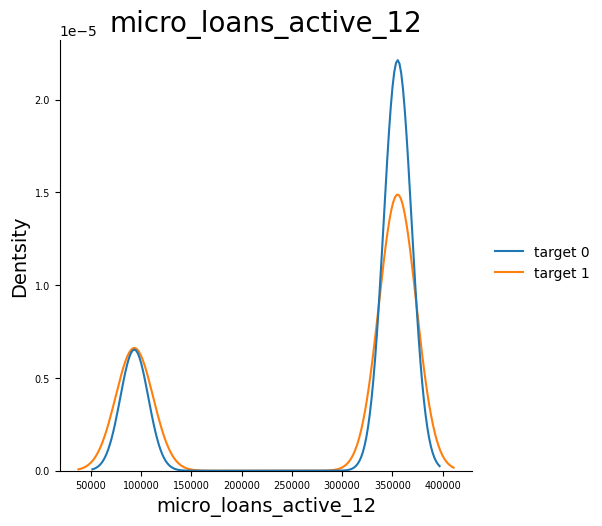

In [54]:
sns.displot(
    {
        "target 0" : df[df.target == 0].micro_loans_active_12,
        "target 1" : df[df.target == 1].micro_loans_active_12
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('micro_loans_active_12', fontsize=20)

plt.xlabel('micro_loans_active_12', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [55]:
df.groupby('target')['micro_loans_active_12'].median()

target
0.0    355259.75
1.0    355259.75
Name: micro_loans_active_12, dtype: float64

In [56]:
df.groupby('target')['open_sum_12'].mean()

target
0.0    406136.622425
1.0    378587.117424
Name: open_sum_12, dtype: float64

In [57]:
df.groupby('target')['open_sum_12'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,open_sum_12
0,0.0,490692.25
1,1.0,490692.25


В ходе анализа были рассмотрены столбцы: open_sum_1, open_sum_3, open_sum_12, micro_loans_active_100, micro_loans_active_12, micro_loans_active_3 и micro_loans_active_1.  
В данном проекте оставил демонстрацию только **open_sum_12 и micro_loans_active_12**

**Вывод** по анализу гипотезы о том, что Активная сумма кредитов влияет на банкротство: чем больше у заемщика задолженность - больше вероятности стать банкротом можно сказать следующее:  
У хороших заемщиков среднее выше чем у плохих в среднем ~7%.  
Медиана и мода практически не отличаются у всех показателей.  

По графику распределения видно, что на "более мелких" суммах разницы не видно. При увеличении суммы количество "хороших" заемщиков увеличивается.

Таким образом гипотеза, что чем больше сумма кредита - тем выше вероятность банкротства неверна.

### Гипотеза 3: is_lost
Количество невозвращенных кредитов влияет на банкротство, чем больше у заемщика невозвращенных кредитов - больше вероятности стать банкротом;

Количество невозвращенных кредитов:

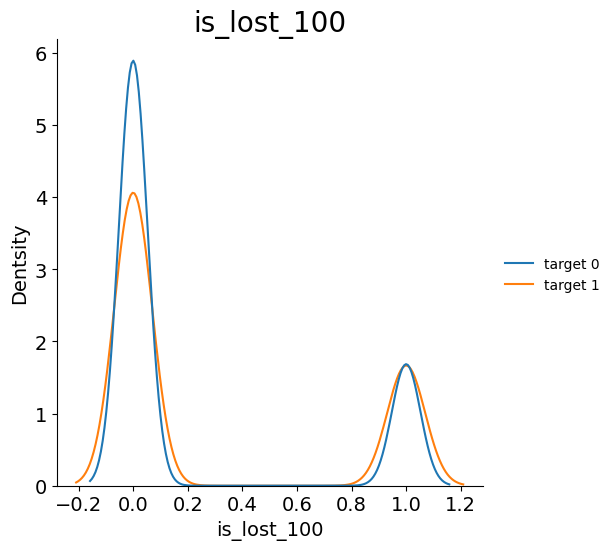

In [58]:
sns.displot(
    {
        "target 0" : df[df.target == 0].is_lost_100,
        "target 1" : df[df.target == 1].is_lost_100
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('is_lost_100', fontsize=20)

plt.xlabel('is_lost_100', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Посмотрим отличия в медианах по количеству невозвращенных кредитов за все время у "хороших" и "прохих" заемщиков

In [59]:
df.groupby('target')['is_lost_100'].median()

target
0.0    0.0
1.0    0.0
Name: is_lost_100, dtype: float64

Посмотрим отличия в средних по количеству невозвращенных кредитов за все время у "хороших" и "прохих" заемщиков

In [60]:
df.groupby('target')['is_lost_100'].mean()

target
0.0    0.222407
1.0    0.290921
Name: is_lost_100, dtype: float64

Посмотрим отличия в модах по количеству невозвращенных кредитов за все время у "хороших" и "прохих" заемщиков

In [61]:
df.groupby('target')['is_lost_100'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,is_lost_100
0,0.0,0.0
1,1.0,0.0


В ходе анализа были рассмотрены столбцы: is_lost_100, is_lost_12, is_lost_3, is_lost_1.  

В данном проекте оставил демонстрацию только is_lost_100.  
Вывод по анализу гипотезы о том, что количество невозвращенных кредитов влияет на банкротство, чем больше у заемщика невозвращенных кредитов - больше вероятности стать банкротом можно сказать следующее:
У хороших заемщиков среднее количество невозвращенных кредитов ниже чем у плохих.  
Медиана и мода практически не отличаются у всех показателей.

Таким образом нельзя отвергать гипотезу, что количество невозвращенных кредитов влияет на банкротство, чем больше у заемщика невозвращенных кредитов - больше вероятности стать банкротом.

### Гипотеза 4: ratio_history_12
Доля невозращенных кредитов влияет на банкротство - чем выше доля - тем больше вероятность просрочки. Имеет смысл посмотреть последние 12 месяцев (т.к. если смотреть весь период, то можно выявить негативные исторические события: мировые кризисы, потерю работы в прошлом и прочее)

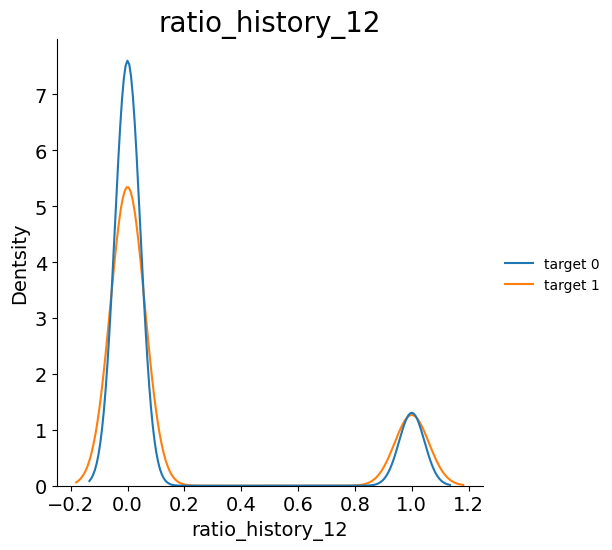

In [62]:
sns.displot(
    {
        "target 0" : df[df.target == 0].ratio_history_12,
        "target 1" : df[df.target == 1].ratio_history_12
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('ratio_history_12', fontsize=20)

plt.xlabel('ratio_history_12', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Посмотрим отличия в медианах по доле невозвращенных кредитов за все время у "хороших" и "прохих" заемщиков

In [63]:
df.groupby('target')['ratio_history_12'].median()

target
0.0    0.0
1.0    0.0
Name: ratio_history_12, dtype: float64

Посмотрим отличия в средних по доле невозвращенных кредитов за все время у "хороших" и "прохих" заемщиков

In [65]:
df.groupby('target')['ratio_history_12'].mean()

target
0.0    0.146503
1.0    0.191405
Name: ratio_history_12, dtype: float64

Посмотрим отличия в модах по доле невозвращенных кредитов за все время у "хороших" и "прохих" заемщиков

In [66]:
df.groupby('target')['ratio_history_12'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,ratio_history_12
0,0.0,0.0
1,1.0,0.0


Вывод по анализу гипотезы о том, что Доля невозращенных кредитов влияет на банкротство - чем выше доля - тем больше вероятность просрочки. Имеет смысл посмотреть последние 12 месяцев (т.к. если смотреть весь период, то можно выявить негативные исторические события: мировые кризисы, потерю работы в прошлом и прочее) можно сказать следующее: У хороших заемщиков средняя доля невозвращенных кредитов ниже чем у плохих.
Медиана и мода практически не отличаются у всех показателей.

Таким образом нельзя отвергать гипотезу, что доля невозвращенных кредитов влияет на банкротство, чем больше у заемщика доля невозвращенных кредитов - больше вероятности стать банкротом.

### Гипотеза 5: ratio_sum_outstanding_to_open_sum
Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю - влияет на банкротство - чем выше доля - тем больше вероятность просрочки. 

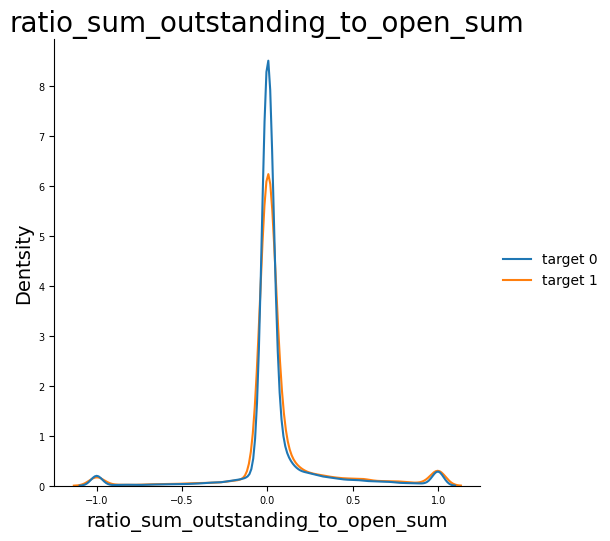

In [69]:
sns.displot(
    {
        "target 0" : df[df.target == 0].ratio_sum_outstanding_to_open_sum,
        "target 1" : df[df.target == 1].ratio_sum_outstanding_to_open_sum
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('ratio_sum_outstanding_to_open_sum', fontsize=20)

plt.xlabel('ratio_sum_outstanding_to_open_sum', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

Посмотрим отличия в медиане по отношению суммы просрочки к общей сумме кредитов среди "хороших" и "прохих" заещиков

In [70]:
df.groupby('target')['ratio_sum_outstanding_to_open_sum'].median()

target
0.0    0.0
1.0    0.0
Name: ratio_sum_outstanding_to_open_sum, dtype: float64

Посмотрим отличия в среднем по отношению суммы просрочки к общей сумме кредитов среди "хороших" и "прохих" заещиков "хороших" и "прохих" заещиков

In [71]:
df.groupby('target')['ratio_sum_outstanding_to_open_sum'].mean()

target
0.0    0.044216
1.0    0.058999
Name: ratio_sum_outstanding_to_open_sum, dtype: float64

Посмотрим отличия по моде по отношению суммы просрочки к общей сумме кредитов среди "хороших" и "прохих" заещиков "хороших" и "прохих" заещиков

In [72]:
df.groupby('target')['ratio_sum_outstanding_to_open_sum'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,ratio_sum_outstanding_to_open_sum
0,0.0,0.0
1,1.0,0.0


**Вывод** по анализу гипотезы о том, что отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю - влияет на банкротство - чем выше доля - тем больше вероятность просрочки. можно сказать следующее:  
У плохих заемщиков среднее выше чем у плохих в среднем ~2%.  
Медиана и мода практически не отличаются у всех показателей.  

Таким образом нельзя отвергать гипотезу, что отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю - влияет на банкротство, а именно чем выше доля - тем больше вероятность просрочки.

### Гипотеза 6: overall_worst_overdue_state_12
Максимальное количество дней просрочки по кредиту - влияет на банкротство - ниже количество дней - тем меньше вероятность банкротства.

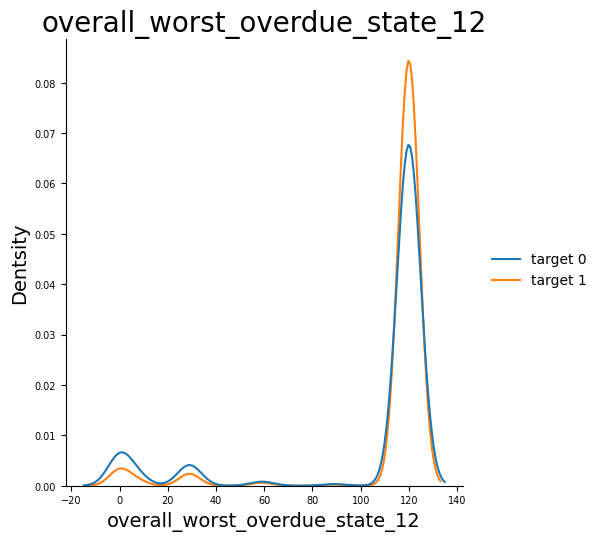

In [73]:
sns.displot(
    {
        "target 0" : df[df.target == 0].overall_worst_overdue_state_12,
        "target 1" : df[df.target == 1].overall_worst_overdue_state_12
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('overall_worst_overdue_state_12', fontsize=20)

plt.xlabel('overall_worst_overdue_state_12', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

Посмотрим отличия в медиане по максимальному количеству дней просрочки "хороших" и "прохих" заещиков

In [74]:
df.groupby('target')['overall_worst_overdue_state_12'].median()

target
0.0    120.0
1.0    120.0
Name: overall_worst_overdue_state_12, dtype: float64

Посмотрим отличия в среднем по максимальному количеству дней просрочки "хороших" и "прохих" заещиков

In [75]:
df.groupby('target')['overall_worst_overdue_state_12'].mean()

target
0.0    103.296586
1.0    111.850640
Name: overall_worst_overdue_state_12, dtype: float64

Посмотрим отличия в моде по максимальному количеству дней просрочки "хороших" и "прохих" заещиков

In [76]:
df.groupby('target')['overall_worst_overdue_state_12'].apply(lambda x: x.value_counts().index[0]).reset_index()

,target,overall_worst_overdue_state_12
0,0.0,120.0
1,1.0,120.0


**Вывод** по анализу гипотезы о том, что максимальное количество дней просрочки по кредиту влияет на банкротство - ниже количество дней - тем меньше вероятность банкротства, можно сказать следующее:  
У хороших заемщиков среднее количество дней ниже чем у плохих в среднем ~9%.  
Медиана и мода практически не отличаются у всех показателей.  

По графику распределения видно, что у "хороших" заемщиков выше плотность распределения на небольших сроках просрочки и ниже на 120 днях.

Таким образом нельзя отвергать гипотезу, что у "хороших" клиентов ниже максимальное количество дней просрочки.

## Вывод по части 1: Провести анализ и охарактеризовать клиентский портфель организации

В рамках анализа выявлено:
1. В данных присуствует большое количество выбросов и аномальных значений. Подробно описано в пункте 2.2.
2. Имеются пропуски, которые, вероятно, появились в рамках некорректной обработки деления на 0.
3. Имеются столбцы с одним значением - возможно ошибка при сборе данных.
4. Из исследовательского анализа выявлено очень большое количество клиентов с просрочками длительностью 120 дней.
5. У всех заемщиков большая закредитованность (большое количество кредитов).
6. Клиентский портфель имеет высокую долю банкротства 27%.

# Подготовка к обучению

Удалим неинформативные признаки, состоящие из нулей

In [77]:
df.drop(['overdue_loans_12', 'overdue_loans_3', 'ratio_overdue_loans_3_to_12'], axis=1, inplace=True)

In [78]:
x = df.drop(['id','target'], axis=1) #признаки для обучения модели
y = df.target # целевой признак

Разделмм данные на тренировочную и тестовую выборки.  
Т.к. в целевом признаке имеется дисбаланс классов применим стратификацию по целевому признаку.

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = RANDOM_STATE,
                                                    stratify=y)

In [80]:
display(f'размер тренировочной выборки {x_train.shape[0]} строк,',
        f'количество строк с классом=1 в целевом признаке {y_train.sum()}'
       )

'размер тренировочной выборки 34016 строк,'

'количество строк с классом=1 в целевом признаке 9438.0'

In [81]:
display(f'размер тренировочной выборки {x_test.shape[0]} строк,',
        f'количество строк с классом=1 в целевом признаке {y_test.sum()}')

'размер тренировочной выборки 8504 строк,'

'количество строк с классом=1 в целевом признаке 2359.0'

# Построим базовые модели логрегрессии и случайного леса.
Результаты работы моделей позволят опрелелить "отправную" точку для улучшения работы следущих моделей

## Логистическая регрессия

Для логистической регрессии стандартизируем данные, чтобы модель лучше обучилась

In [82]:
scaler = StandardScaler()

In [83]:
x_train_sca = x_train.copy()
x_test_sca = x_test.copy()
scaler.fit(x_train_sca)
x_train_sca = scaler.transform(x_train_sca)
x_test_sca = scaler.transform(x_test_sca)

In [84]:
model_lr = LogisticRegression(class_weight='balanced')

In [85]:
model_lr.fit(x_train_sca, y_train)

LogisticRegression(class_weight='balanced')

In [86]:
predict_lr = model_lr.predict(x_test_sca)
predict_lr

array([0., 0., 0., ..., 0., 0., 0.])

In [87]:
matrix_lr = matrix_epic(y_test,predict_lr)

'Истинно негативные - 3565 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 2580 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 1013 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 1346 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 53.8%'

'Доля обанкротившихся клиентов среди одобренных 28.4%'

Базовая модель логистической регрессии отвечает заявленому уровню одобрения (более 35%), но не отвечает требованию по доле просрочки среди них - 29.2%

## Random Forest (n_estimators = 300, 100, 10)

### Random Forest 300
Построим базовую модель случайного леса и посмотрим результаты.  
Т.к. имеем дисбаланс классов будем использовать параметр модели **class_weight='balanced'**

In [88]:
model_fr_300 = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state = RANDOM_STATE)
model_fr_300.fit(x_train, y_train)
predict_rf = model_fr_300.predict(x_test)

In [89]:
matrix = matrix_epic(y_test,predict_rf)

'Истинно негативные - 5872 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 273 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 2149 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 210 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 94.3%'

'Доля обанкротившихся клиентов среди одобренных 36.6%'

### Random Forest 100 

In [90]:
model_fr_100 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state = RANDOM_STATE)
model_fr_100.fit(x_train, y_train)
predict_rf_100 = model_fr_100.predict(x_test)

In [91]:
matrix_rf_100 = matrix_epic(y_test, predict_rf_100)

'Истинно негативные - 5848 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 297 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 2119 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 240 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 93.7%'

'Доля обанкротившихся клиентов среди одобренных 36.2%'

### Random Forest 10

In [92]:
model_fr_10 = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state = RANDOM_STATE)
model_fr_10.fit(x_train, y_train)
predict_rf_10 = model_fr_10.predict(x_test)

In [93]:
matrix_rf_10 = matrix_epic(y_test, predict_rf_10)

'Истинно негативные - 5667 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 478 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 2052 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 307 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 90.8%'

'Доля обанкротившихся клиентов среди одобренных 36.2%'

**ВЫВОД:**  
В качестве базовой модели "хорошо" правилась с понимания "отправной" точки модель логистической регрессии.  
Получили:  
- Доля одобрений 54.0%  
- Доля обанкротившихся клиентов среди одобренных 28.9%

При это получили слишком большое значение:  
"Ложно позиивные" - 3228 - мы предсказали, что клиенты станут банкротами, но ошиблись! Данным клиентам можно выдавать кредиты.  
Необходимо постоить модель, которая большее лучше сможет предсказывать Истинные значения.

### Важность признаков:  
Отобразим таблицу важности признаков на графике

<Axes: ylabel='Feature'>

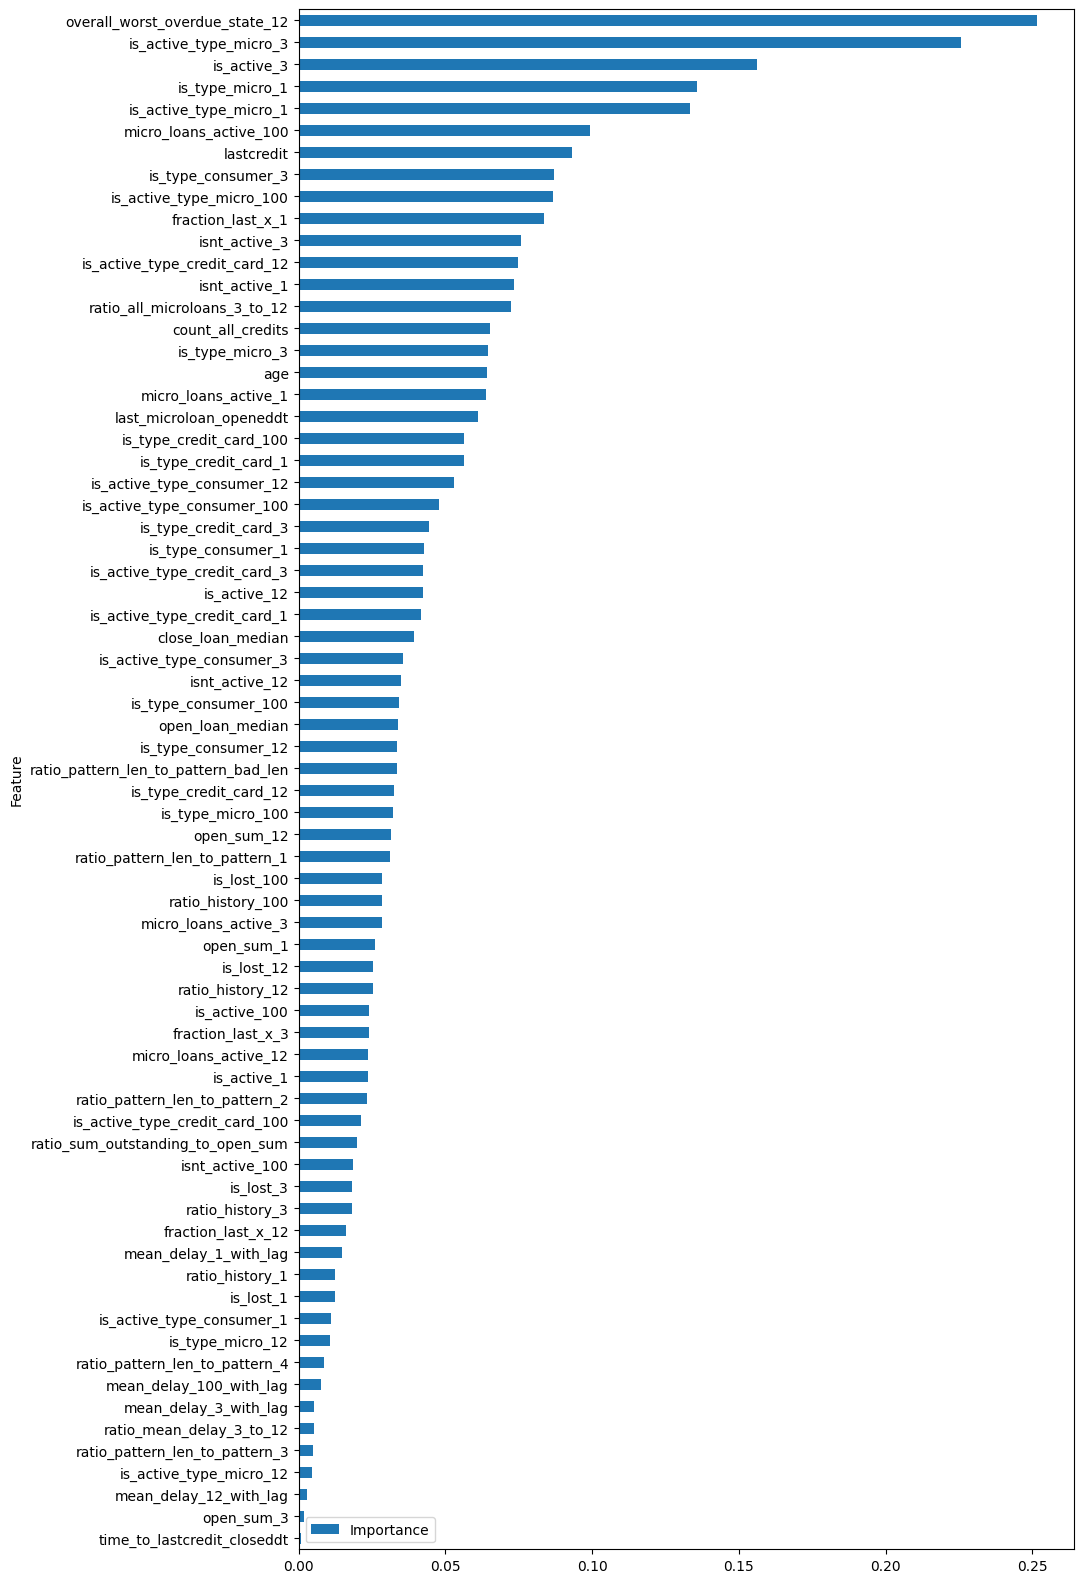

In [94]:
coefficients = model_lr.coef_[0]
feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 20))

Посмотрим какие признаки имеют вес в модели более 5%:

In [95]:
feature_importance_list = feature_importance.loc[feature_importance['Importance'] > 0.05, 'Feature']
feature_importance_list

54        is_active_type_consumer_12
62             is_type_credit_card_1
44           is_type_credit_card_100
43           last_microloan_openeddt
23              micro_loans_active_1
0                                age
58                   is_type_micro_3
37                 count_all_credits
24      ratio_all_microloans_3_to_12
21                     isnt_active_1
53     is_active_type_credit_card_12
16                     isnt_active_3
31                 fraction_last_x_1
49          is_active_type_micro_100
57                is_type_consumer_3
1                         lastcredit
8             micro_loans_active_100
67            is_active_type_micro_1
64                   is_type_micro_1
14                       is_active_3
61            is_active_type_micro_3
68    overall_worst_overdue_state_12
Name: Feature, dtype: object

# Построение модели

## Буду использовать CATBOOST + GridSearchCV
В качестве гиперпараметров переберу:
- количество деревьев;
- глубину деревьев;
- скорость обучения.

In [96]:
"""Перебор гиперпараметров и обучение заняли 1 день и 1 час. Но после этого тетрадка перезапустилась. Ниже код и результаты"""
"""
estimators_range = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
max_depth_range = [int(x) for x in np.linspace(start = 1, stop = 15, num = 5)]

model_cb = CatBoostClassifier(random_state=RANDOM_STATE, 
                              verbose=50, 
                              auto_class_weights='Balanced', #укажем для устранения дисбаланса
                              early_stopping_rounds=20,      #зададим условия ранней остановки
                              snapshot_file='shapshot.bkp',  #укажим для возобновления в случае прерывания расчетов
                              snapshot_interval=1)

params_cb = {
             'n_estimators': estimators_range,
             'max_depth': max_depth_range,
             'learning_rate' : [0.15, 0.3, 0.5],
            }


grid = GridSearchCV(estimator=model_cb,
                    param_grid = params_cb,
                    cv=5,
                    verbose=1,
                    scoring='f1', 
                    n_jobs=-1)


grid.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits  
0:	learn: 0.6892563	total: 2.11s	remaining: 2m 33s  
50:	learn: 0.6635117	total: 4.5s	remaining: 2.03s  
73:	learn: 0.6598077	total: 6.54s	remaining: 0us  
CPU times: total: 22.2 s  
Wall time: 1d 1h 26min 5s  
GridSearchCV(cv=5,  
             estimator=<catboost.core.CatBoostClassifier object at 0x0000012BAAF58CD0>,  
             n_jobs=-1,  
             param_grid={'learning_rate': [0.15, 0.3, 0.5],  
                         'max_depth': [1, 4, 8, 11, 15],  
                         'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235,  
                                          267, 300]},  
             scoring='f1', verbose=1) 
             
grid.best_estimator_             

grid.best_params_

Лучшие параметры выявленные на кроссвалидации  
{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 74}
"""

"\nestimators_range = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]\nmax_depth_range = [int(x) for x in np.linspace(start = 1, stop = 15, num = 5)]\n\nmodel_cb = CatBoostClassifier(random_state=RANDOM_STATE, \n                              verbose=50, \n                              auto_class_weights='Balanced', #укажем для устранения дисбаланса\n                              early_stopping_rounds=20,      #зададим условия ранней остановки\n                              snapshot_file='shapshot.bkp',  #укажим для возобновления в случае прерывания расчетов\n                              snapshot_interval=1)\n\nparams_cb = {\n             'n_estimators': estimators_range,\n             'max_depth': max_depth_range,\n             'learning_rate' : [0.15, 0.3, 0.5],\n            }\n\n\ngrid = GridSearchCV(estimator=model_cb,\n                    param_grid = params_cb,\n                    cv=5,\n                    verbose=1,\n                    scoring='f1', \n        

Загружу сохраненную модель

In [97]:
model_cb = CatBoostClassifier()
model_cb.load_model('model.cbm')
model_cb

In [98]:
model_cb.get_params()

{'od_wait': 20,
 'snapshot_file': 'shapshot.bkp',
 'verbose': 50,
 'iterations': 74,
 'auto_class_weights': 'Balanced',
 'snapshot_interval': 1,
 'loss_function': 'Logloss',
 'depth': 4,
 'random_seed': 1122,
 'learning_rate': 0.15}

Выполним предсказание на тестовых признаках

In [99]:
model_cb.fit(x_train, y_train)

0:	learn: 0.6893991	total: 847ms	remaining: 1m 1s
50:	learn: 0.6636840	total: 2.65s	remaining: 1.2s
73:	learn: 0.6602782	total: 3.48s	remaining: 0us


In [100]:
predict_cb = model_cb.predict(x_test)
predict_cb

array([0., 0., 0., ..., 0., 0., 0.])

Построим матрицу ошибок для предсказаний модели CatBoost

In [101]:
matrix_epic(y_test,predict_cb)

'Истинно негативные - 3573 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 2572 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 994 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 1365 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 53.7%'

'Доля обанкротившихся клиентов среди одобренных 27.8%'

array([[3573, 2572,  994, 1365]], dtype=int64)

**Промежуточный вывод:** Получили долю обанкротившихся среди одобренных чуть лучше "текущей" по портфелю (27.2 в сравнении с 27,7%)

In [102]:
model_feature_impotances = model_cb.feature_importances_
model_feature_impotances

array([ 5.59427401,  1.1465996 ,  0.        ,  0.19471005,  1.2665286 ,
        0.54327951,  1.359168  ,  0.30850929,  3.52152362,  1.5690169 ,
        0.23967589,  2.73434379,  1.93287102,  0.96174069,  0.43170119,
        1.11615137,  2.43377637,  0.35261481,  0.        ,  0.88171509,
        1.72063085,  2.06944234,  0.        ,  0.74717664,  3.50302123,
        1.84066061,  1.38425821,  3.5726766 ,  1.24893637,  3.48047137,
        0.68688641,  2.31854122,  0.        ,  0.55266772,  0.51044293,
        0.3224167 ,  1.33100561,  1.86809788,  0.65589959,  0.        ,
        0.        ,  0.        ,  0.69958594,  1.31998166,  2.9008182 ,
        0.82783989,  1.63606165,  0.        ,  0.54870372,  1.01665447,
        0.07400965,  0.        ,  0.08498951,  0.22807718,  0.        ,
        0.69810764,  0.1504282 ,  1.48481085,  2.52416293,  0.        ,
        0.        ,  2.01288487,  0.09912537,  1.11366453,  3.8714775 ,
        0.05412642,  0.        ,  0.93695573, 20.72645792,  2.58

In [103]:
df_features = pd.DataFrame(data=model_feature_impotances, index=x_train.columns, columns=['Важность'])
df_features.sort_values(by = 'Важность', ascending=False, inplace=True)
df_features

,Важность
overall_worst_overdue_state_12,20.726458
age,5.594274
is_type_micro_1,3.871478
fraction_last_x_12,3.572677
micro_loans_active_100,3.521524
...,...
ratio_pattern_len_to_pattern_2,0.000000
ratio_pattern_len_to_pattern_4,0.000000
is_active_type_credit_card_100,0.000000
is_active_type_consumer_12,0.000000


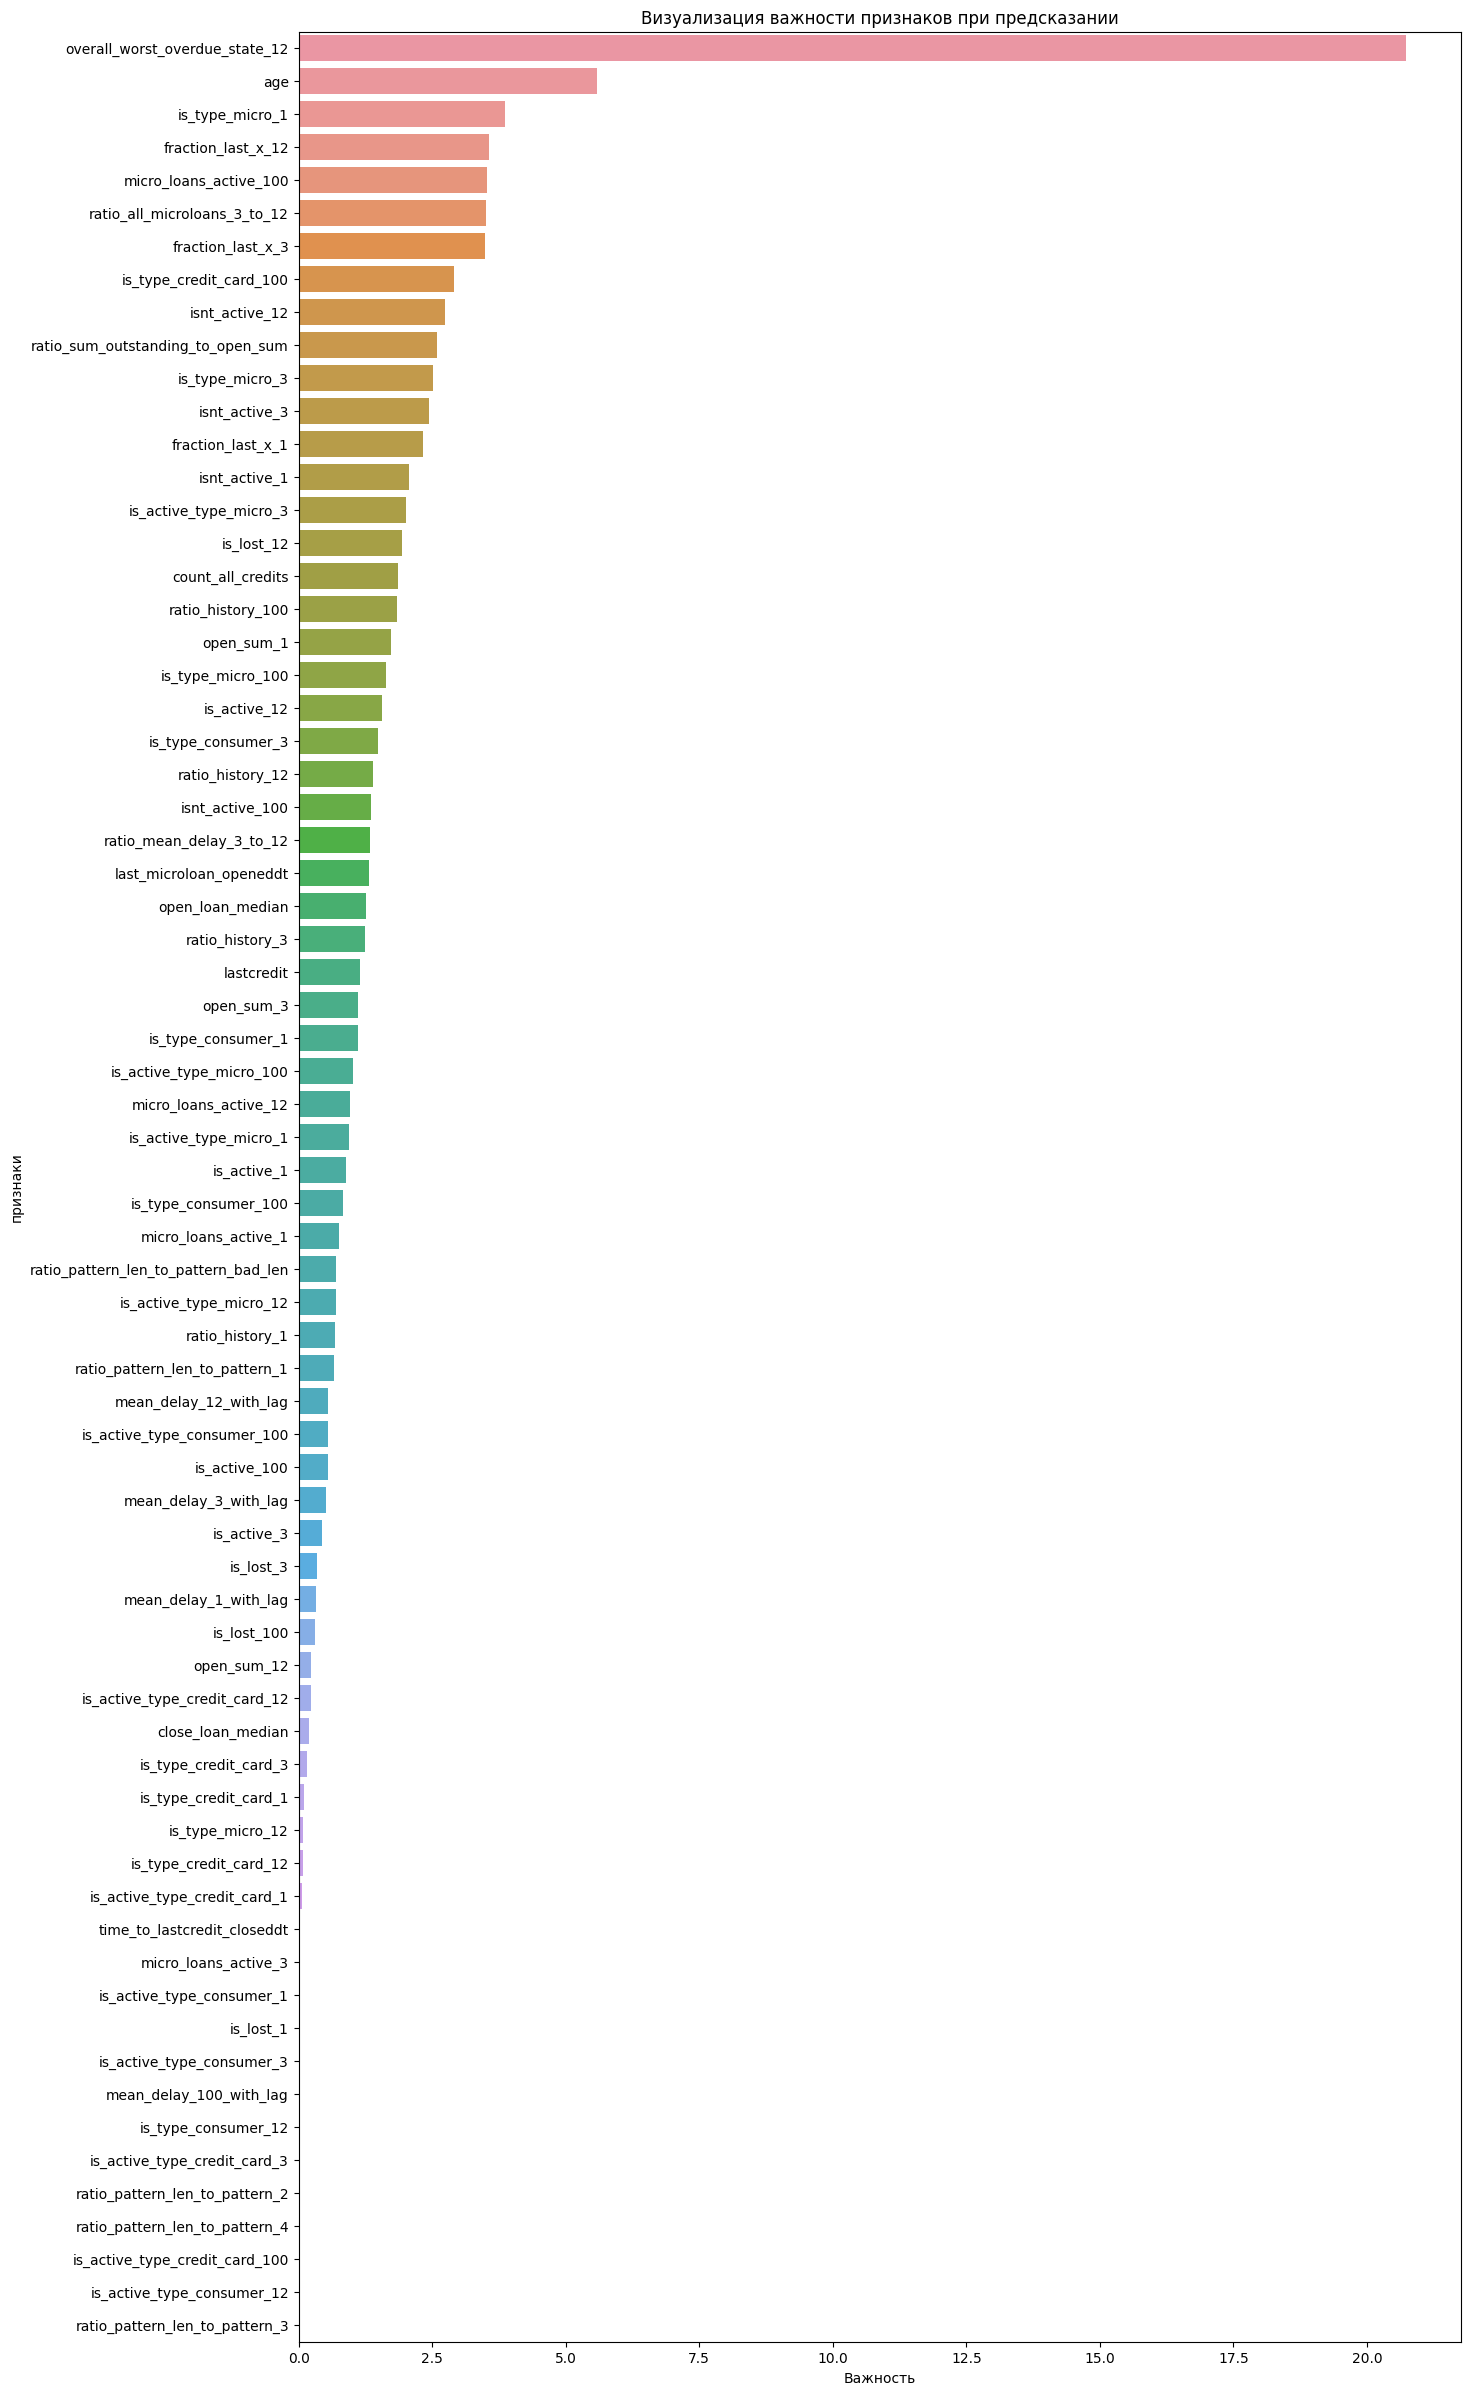

In [104]:
plt.figure(figsize=(15,30))
sns.barplot(data=df_features, x='Важность', y=df_features.index)
plt.ylabel('признаки')
plt.title('Визуализация важности признаков при предсказании')
plt.show()

Выведем признаки, важность которых более 1%.

In [105]:
df_features_list = list(df_features.loc[df_features['Важность'] > 1].index)
df_features_list

['overall_worst_overdue_state_12',
 'age',
 'is_type_micro_1',
 'fraction_last_x_12',
 'micro_loans_active_100',
 'ratio_all_microloans_3_to_12',
 'fraction_last_x_3',
 'is_type_credit_card_100',
 'isnt_active_12',
 'ratio_sum_outstanding_to_open_sum',
 'is_type_micro_3',
 'isnt_active_3',
 'fraction_last_x_1',
 'isnt_active_1',
 'is_active_type_micro_3',
 'is_lost_12',
 'count_all_credits',
 'ratio_history_100',
 'open_sum_1',
 'is_type_micro_100',
 'is_active_12',
 'is_type_consumer_3',
 'ratio_history_12',
 'isnt_active_100',
 'ratio_mean_delay_3_to_12',
 'last_microloan_openeddt',
 'open_loan_median',
 'ratio_history_3',
 'lastcredit',
 'open_sum_3',
 'is_type_consumer_1',
 'is_active_type_micro_100']

In [106]:
output_test = pd.DataFrame({'id': y_test.index, 'predict': predict_cb})
output_test.to_csv('submission_predict.csv', index=False)

## Изменение порога

В связи с тем, что мы имеем высокий показатель False Positive (модель ошибочно определеяет большое количество клиентов как банкротов) и False Negative (модель не достаточно хорошо определяет банкротов (выше заявленной планки в 15% от одобренных), попробуем изменить порог отнесения клиетов к классу "банкрот".  
По умолчанию в модели используется порог 0.5. 
Изменим порог до 0.465, т.к. относить клиета к плохому будем если "по оценки модели" отнесение клиента к классу банкрот выше 0.465%.  

In [107]:
predict_probability = model_cb.predict_proba(x_test)
predict_probability

array([[0.54145587, 0.45854413],
       [0.61515571, 0.38484429],
       [0.54698494, 0.45301506],
       ...,
       [0.52628779, 0.47371221],
       [0.68871639, 0.31128361],
       [0.65755675, 0.34244325]])

### Порог 0.462

In [108]:
matrix_epic(y_test,predict_cb)

'Истинно негативные - 3573 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 2572 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 994 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 1365 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 53.7%'

'Доля обанкротившихся клиентов среди одобренных 27.8%'

array([[3573, 2572,  994, 1365]], dtype=int64)

In [129]:
df_probability = pd.DataFrame(predict_probability)

df_probability['treshhold_462'] = 0
df_probability.loc[df_probability[1] > .462, 'treshhold_462'] = 1
df_probability

,0,1,treshhold_462
0,0.541456,0.458544,0
1,0.615156,0.384844,0
2,0.546985,0.453015,0
3,0.436803,0.563197,1
4,0.513823,0.486177,1
...,...,...,...
8499,0.472882,0.527118,1
8500,0.577572,0.422428,0
8501,0.526288,0.473712,1
8502,0.688716,0.311284,0


In [130]:
matrix_epic(y_test,df_probability['treshhold_462'])

'Истинно негативные - 2445 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 3700 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 545 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 1814 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 35.2%'

'Доля обанкротившихся клиентов среди одобренных 22.3%'

array([[2445, 3700,  545, 1814]], dtype=int64)

### Сравнение модели CatBoost с базовой моделью логистической регрессии с применением порога

In [116]:
predict_probability_lr = model_lr.predict_proba(x_test_sca)
predict_probability_lr

array([[0.56353286, 0.43646714],
       [0.58475632, 0.41524368],
       [0.55334892, 0.44665108],
       ...,
       [0.55020005, 0.44979995],
       [0.67056477, 0.32943523],
       [0.67955844, 0.32044156]])

In [131]:
df_probability_lr = pd.DataFrame(predict_probability_lr)

df_probability_lr['treshhold_455'] = 0
df_probability_lr.loc[df_probability_lr[1] > .455, 'treshhold_455'] = 1
df_probability_lr

,0,1,treshhold_455
0,0.563533,0.436467,0
1,0.584756,0.415244,0
2,0.553349,0.446651,0
3,0.447377,0.552623,1
4,0.522640,0.477360,1
...,...,...,...
8499,0.345621,0.654379,1
8500,0.560182,0.439818,0
8501,0.550200,0.449800,0
8502,0.670565,0.329435,0


In [132]:
matrix_epic(y_test,df_probability_lr['treshhold_455'])

'Истинно негативные - 2402 предсказаний (клиенты, получившие кредит, не станут банкротами)'

'Ложно позиивные - 3743 предсказаний (мы предсказали, что клиенты станут банкротами, но ошиблись!)'

'Ложно негативные - 577 предсказаний (мы предсказали, что клиенты не станут банкротами, но ошиблись!)'

'Истинно позитивные - 1782 предсказаний (клиенты, получившие кредит, станут банкротами)'

'Доля одобрений 35.0%'

'Доля обанкротившихся клиентов среди одобренных 24.0%'

array([[2402, 3743,  577, 1782]], dtype=int64)

## Вывод по части 2: моделирование:
Перед нами стояла задача: Построить базовую модель прогнозирования банкротства, одобряющую не менее 35% клиентов при банкротстве среди одобренных не выше 15%.  

Базовая модель Логистической регрессии с порогом 0.455 показала: 
- долю одобрения 35,0%
- доля обанкротившихся среди одобренных 24,0%.

Для улучшения релузьтатов использовал модель CatBoost, подбор гиперпараметров и кроссвалидацию в GridSearchCV.
Наилучшие параметры модели для CatBoost получились следующие:
- количесво деревьев - 74;
- глубина деревьев - 4;
- скорость обучения - 0.15.

Благодаря данным покателям при пороге 0.462 получилось достичь:
- долю одобрения 35,2%
- доля обанкротившихся среди одобренных 22,4%.

Таким образом Catboost и Логистическая регрессия имеют практически одиковый процент одобрения (35,1 и 35 соответственно), но Catboost показал на 1.6% ниже количество банкротов из одобренных. 

Считаю, что для модели кредитного скоринга дополнительное выявление 1.6% клиентов банкотов из одобренных является важным результатом.

**Итог:**   
Поставленную задачу: построить модель, которая будет одобрять более 35% кредитов решили.  
Но доля просрочки среди этих клиентов получилась выше 22.4% (Вместо 15%).  
Если бы мы использовали данную модель перед выдачей кредитов которые анализировали, то доля банкротов сократилась бы, т.к. текущая доля банкротов в портфеле 27.7%.  

В реальной задаче можно было пытаться перебрать больше параметров для модели, использовать бинеразиацию количественных признаков и подбор порога для получения необходимых результатов, но из-за с ограниченного времени на выполнению задачи оставлю реультаты в таком виде.

# Рекомендации 

## Изменение признакового пространства

Если исходить из предоставленного набора данных, то на мой взгляд имеет смысл добавить:  
- open_sum_100 - Активная сумма кредитов, взятых за все время (по аналогии с периодами 12, 3 и 1 мес и с суммой микрокредитов)

Если говорить о новых признаках для модели (для физических лиц):
- Образование;
- Регион регистрации заемщика;
- Регион фактического проживания заемщика;
- Сфера деятельности (род деятельности);
- Рабочий стаж заемщика;
- Заработную плату заемщика;
- Среднюю заработную плату по регионе проживания заемщика;
- Пол;
- Рейтинг БКИ;
- Количество запросов в БКИ;
- Отношение количества полученных кредитов к количеству запросов в БКИ;
- Семейное положение;
- Количество детей;
- Цель кредита;
- Другими: например наличие автомобиля, недвижимости, уровнем расходов и пр

## Развитие базовой модели

Для развития базовой модели можно дополнительно использовать:  
- продолжить подбирать гиперпараметры;
- использовать только "значимые" признаки;
- управление порогом (treshhold) для отнесения клиента к тому или иному классу; 
- поработать с признаками, некоторые признаки предположительно можно преобраозовать (например логарифмировать), что может дать положительный вклад в обучение модели;
- binning (разбиение на интервалы) значений количественных признаков;  
- обучать модель на большем количестве данных (это актуально для моделей кредитного скоринга, т.к. данные имеются в "обезличенных песочницах", а также по причине очень высоких рисках для кредитных организаций по невозврату кредитов и дополнительных резеврах)